In [100]:
#import libraries
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy
import pickle
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from scikitplot.metrics import plot_roc, plot_precision_recall
import pathlib

In [101]:
def save_pkl(pkl_object, file_name):
    pkl_file = open(file_name, 'wb')
    pickle.dump(pkl_object, pkl_file)
    pkl_file.close()
    

def unpkl(file_name):
    file = open(file_name,'rb')
    obj = pickle.load(file)
    file.close()
    return obj

def train_model(model, criterion, optimizer, scheduler, device, dataloaders, dataset_sizes, 
                num_epochs=25, return_history=False, log_history=True, working_dir='output'):
    start = time.time()
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'epoch' : [], 'train_loss' : [], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propagate
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # back propagate and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history['epoch'].append(epoch)
            history[phase+'_loss'].append(epoch_loss)
            history[phase+'_acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        if log_history:
            save_pkl(history,os.path.join(working_dir,'model_history.pkl'))
        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model
    print('Returning object of best model.')
    model.load_state_dict(best_model_wts)
    
    if return_history:
        return model, history
    else:
        return model

In [102]:
#visualize
def imshow(inp, title=None, figsize=(20,8)):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

    
def visualize_model_grid(model, class_names, device, dataloaders, num_images=6, figsize=(20,20), images_per_row=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=figsize)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                
                ax = plt.subplot(num_images//images_per_row, images_per_row, images_so_far)
                ax.axis('off')
                plt.imshow(inp)
                
                if labels[j] == preds[j]:
                    predict_statement = 'CORRECT PREDICTION'
                else:
                    predict_statement = 'ERROR IN PREDICTION'
                
                plt.title('{} \n Actual: {} \n Predicted: {}'.format(predict_statement, class_names[labels[j]], class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def get_title_string_from_classes(classes, class_names):
    title_str = ''
    for i_x,x in enumerate(classes):
        if i_x !=0 and i_x % 4 == 0:
            title_str = title_str+' ||\n'
        title_str = title_str + ' || ' + class_names[x]
    return title_str


In [103]:
#transforms
def makeTransforms(img_crop_size=224, img_resize=256):
    # Data augmentation and normalization for training
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(img_crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(img_resize),
            transforms.CenterCrop(img_crop_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms

In [104]:
#evaluation
def make_predictions_proba(model, dataloaders, device):
    was_training = model.training
    model.eval()
    images_so_far = 0


    print('Commencing predictions minibatch..', end='')
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            if i % 25 == 0:
                print('{}..'.format(i), end='')

            inputs = inputs.to(device)
            labels = labels.to(device)


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            if i == 0:
                labels_truth = labels.cpu().numpy()
                labels_pred = preds.cpu().numpy()
                scores_pred = outputs.cpu().numpy()
            else:
                labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
                labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
                scores_pred= np.concatenate((scores_pred,outputs.cpu().numpy()))

    print('Complete.')

    return {'labels truth' : labels_truth, 'labels pred' : labels_pred, 'scores pred' : scores_pred}

In [73]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)


In [105]:
data_dir = pathlib.Path('data')
working_dir = 'output'

batch_size = 8
num_workers = 4
num_epochs = 15
nrows_plot= 4

os.makedirs(working_dir, exist_ok=True)

In [106]:
data_transforms = makeTransforms()

In [107]:
# data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

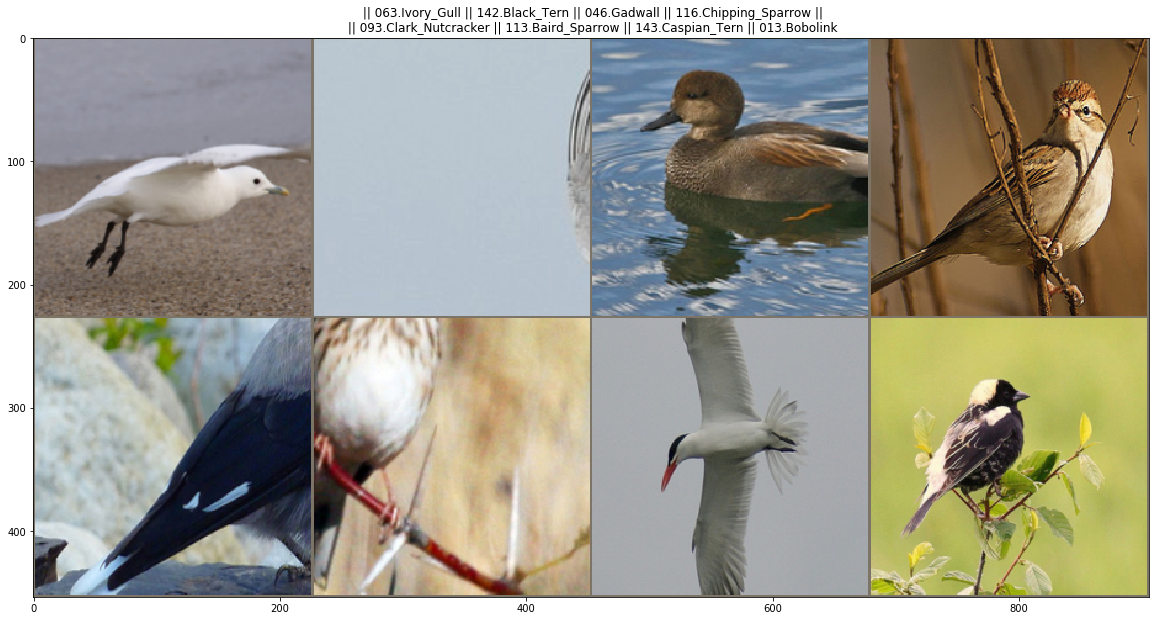

In [108]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make grid from batch
out = torchvision.utils.make_grid(inputs, nrow=nrows_plot)

imshow(out, title=get_title_string_from_classes(classes, class_names), figsize=(20,20))

In [109]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 5994
    Root location: data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [110]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 5794
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

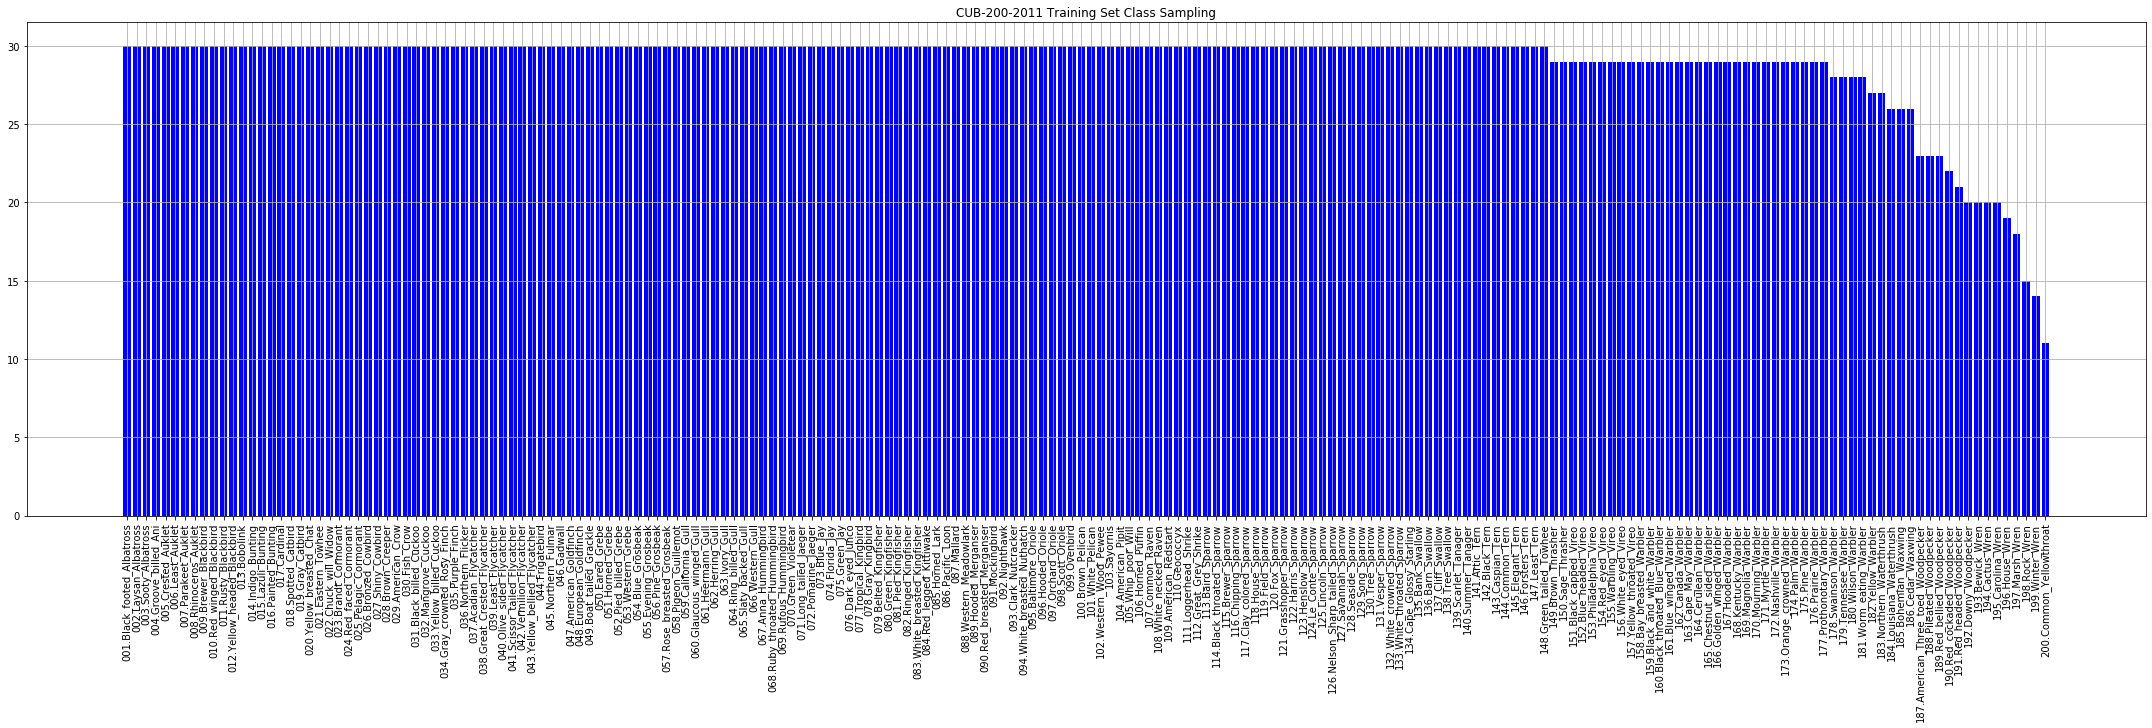

{'train': {'001.Black_footed_Albatross': 30,
  '002.Laysan_Albatross': 30,
  '003.Sooty_Albatross': 28,
  '004.Groove_billed_Ani': 30,
  '005.Crested_Auklet': 14,
  '006.Least_Auklet': 11,
  '007.Parakeet_Auklet': 23,
  '008.Rhinoceros_Auklet': 18,
  '009.Brewer_Blackbird': 29,
  '010.Red_winged_Blackbird': 30,
  '011.Rusty_Blackbird': 30,
  '012.Yellow_headed_Blackbird': 26,
  '013.Bobolink': 30,
  '014.Indigo_Bunting': 30,
  '015.Lazuli_Bunting': 28,
  '016.Painted_Bunting': 28,
  '017.Cardinal': 27,
  '018.Spotted_Catbird': 15,
  '019.Gray_Catbird': 29,
  '020.Yellow_breasted_Chat': 29,
  '021.Eastern_Towhee': 30,
  '022.Chuck_will_Widow': 26,
  '023.Brandt_Cormorant': 29,
  '024.Red_faced_Cormorant': 22,
  '025.Pelagic_Cormorant': 30,
  '026.Bronzed_Cowbird': 30,
  '027.Shiny_Cowbird': 30,
  '028.Brown_Creeper': 29,
  '029.American_Crow': 30,
  '030.Fish_Crow': 30,
  '031.Black_billed_Cuckoo': 30,
  '032.Mangrove_Cuckoo': 23,
  '033.Yellow_billed_Cuckoo': 29,
  '034.Gray_crowned_Ro

In [111]:
class_sampling = {'train' : {}, 'test' : {}}
for stage in ['train','test']:
    for i_class, class_name in enumerate(class_names):
        class_sampling[stage][class_name] = (np.array(image_datasets['test'].targets) == i_class).sum()

plt.figure(figsize=(30,10))
plt.bar(x=class_names, height=pd.DataFrame(class_sampling)['train'].sort_values(ascending=False),color='blue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.title('CUB-200-2011 Training Set Class Sampling')
plt.show()
class_sampling

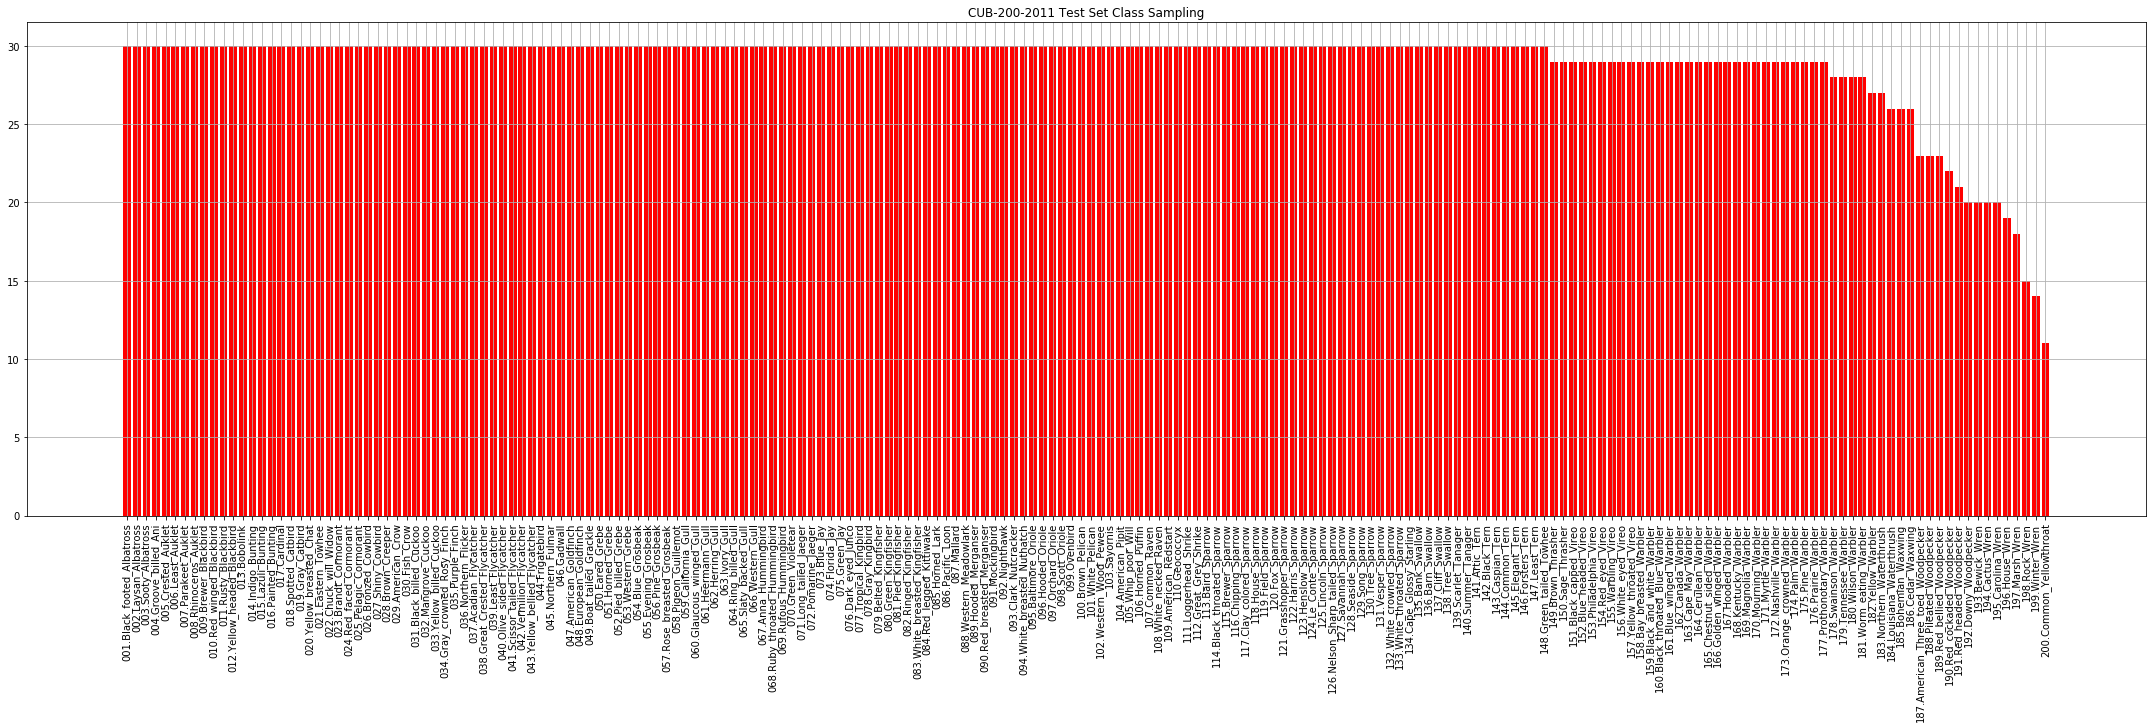

In [112]:
plt.figure(figsize=(30,10))
plt.bar(x=class_names, height=pd.DataFrame(class_sampling)['test'].sort_values(ascending=False),color='red')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.title('CUB-200-2011 Test Set Class Sampling')
plt.show()

In [15]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [16]:
# Setup the model and optimiser
model_ft = models.resnext101_32x8d(pretrained=True)

In [17]:
num_ftrs = model_ft.fc.in_features
# size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

In [18]:
model_ft = model_ft.to(device)

In [19]:
#Loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model_ft = train_model(model=model_ft, criterion=criterion, optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                       device=device, dataloaders=dataloaders, dataset_sizes=dataset_sizes, num_epochs=15)

Epoch 0/14
----------
train Loss: 4.0353 Acc: 0.1567
test Loss: 1.9967 Acc: 0.4726

Epoch 1/14
----------
train Loss: 2.3407 Acc: 0.4418
test Loss: 1.1920 Acc: 0.6363

Epoch 2/14
----------
train Loss: 1.7029 Acc: 0.5822
test Loss: 0.9992 Acc: 0.7031

Epoch 3/14
----------
train Loss: 1.4375 Acc: 0.6458
test Loss: 0.8831 Acc: 0.7454

Epoch 4/14
----------
train Loss: 1.2449 Acc: 0.6839
test Loss: 0.8365 Acc: 0.7573

Epoch 5/14
----------
train Loss: 1.0840 Acc: 0.7291
test Loss: 0.8187 Acc: 0.7722

Epoch 6/14
----------
train Loss: 0.9853 Acc: 0.7548
test Loss: 0.8119 Acc: 0.7768

Epoch 7/14
----------
train Loss: 0.7901 Acc: 0.8178
test Loss: 0.6280 Acc: 0.8234

Epoch 8/14
----------
train Loss: 0.7117 Acc: 0.8380
test Loss: 0.6087 Acc: 0.8307

Epoch 9/14
----------
train Loss: 0.6586 Acc: 0.8547
test Loss: 0.5940 Acc: 0.8348

Epoch 10/14
----------
train Loss: 0.6378 Acc: 0.8594
test Loss: 0.5860 Acc: 0.8400

Epoch 11/14
----------
train Loss: 0.6313 Acc: 0.8595
test Loss: 0.5860 Acc

In [113]:
# Load model training history
model_history = 'output/model_history.pkl'
history = unpkl(model_history)

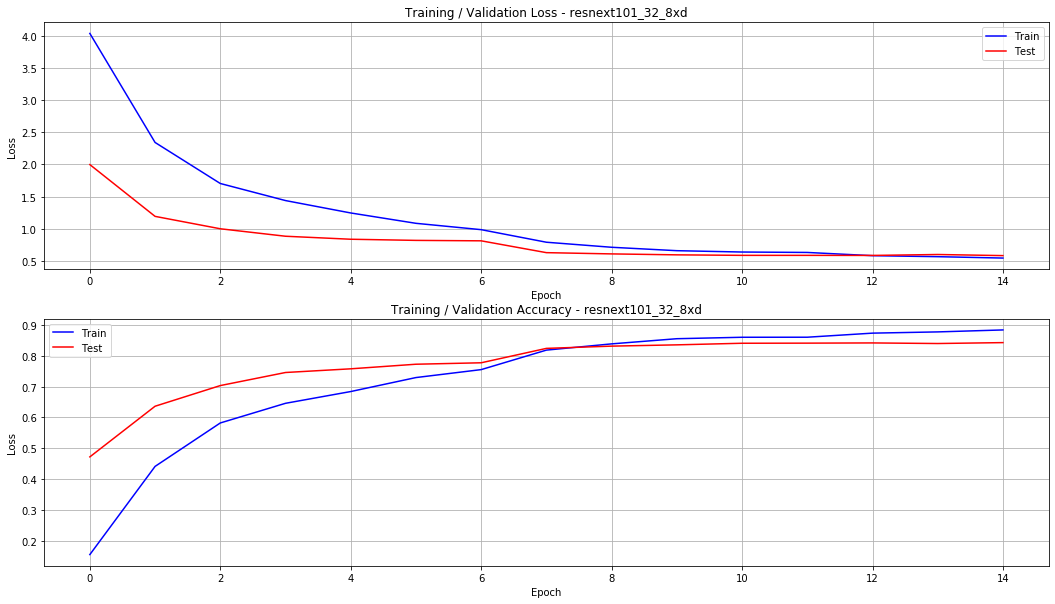

In [114]:
model_name = 'resnext101_32_8xd'
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - {}'.format(model_name))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - {}'.format(model_name))
plt.legend()

plt.show()

In [115]:
torch.save(model_ft, 'output/caltech_birds_resnext101_32x8d_full.pth')
torch.save(model_ft.state_dict(), 'output/caltech_birds_resnext101_32x8d_dict.pth')

In [116]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets[['test'][0]].classes

In [117]:
# Load the best model from file
model_name = 'resnext101_32x8d'
model_file = os.path.join(working_dir, 'caltech_birds_{}_full.pth'.format(model_name))
model = torch.load(model_file)

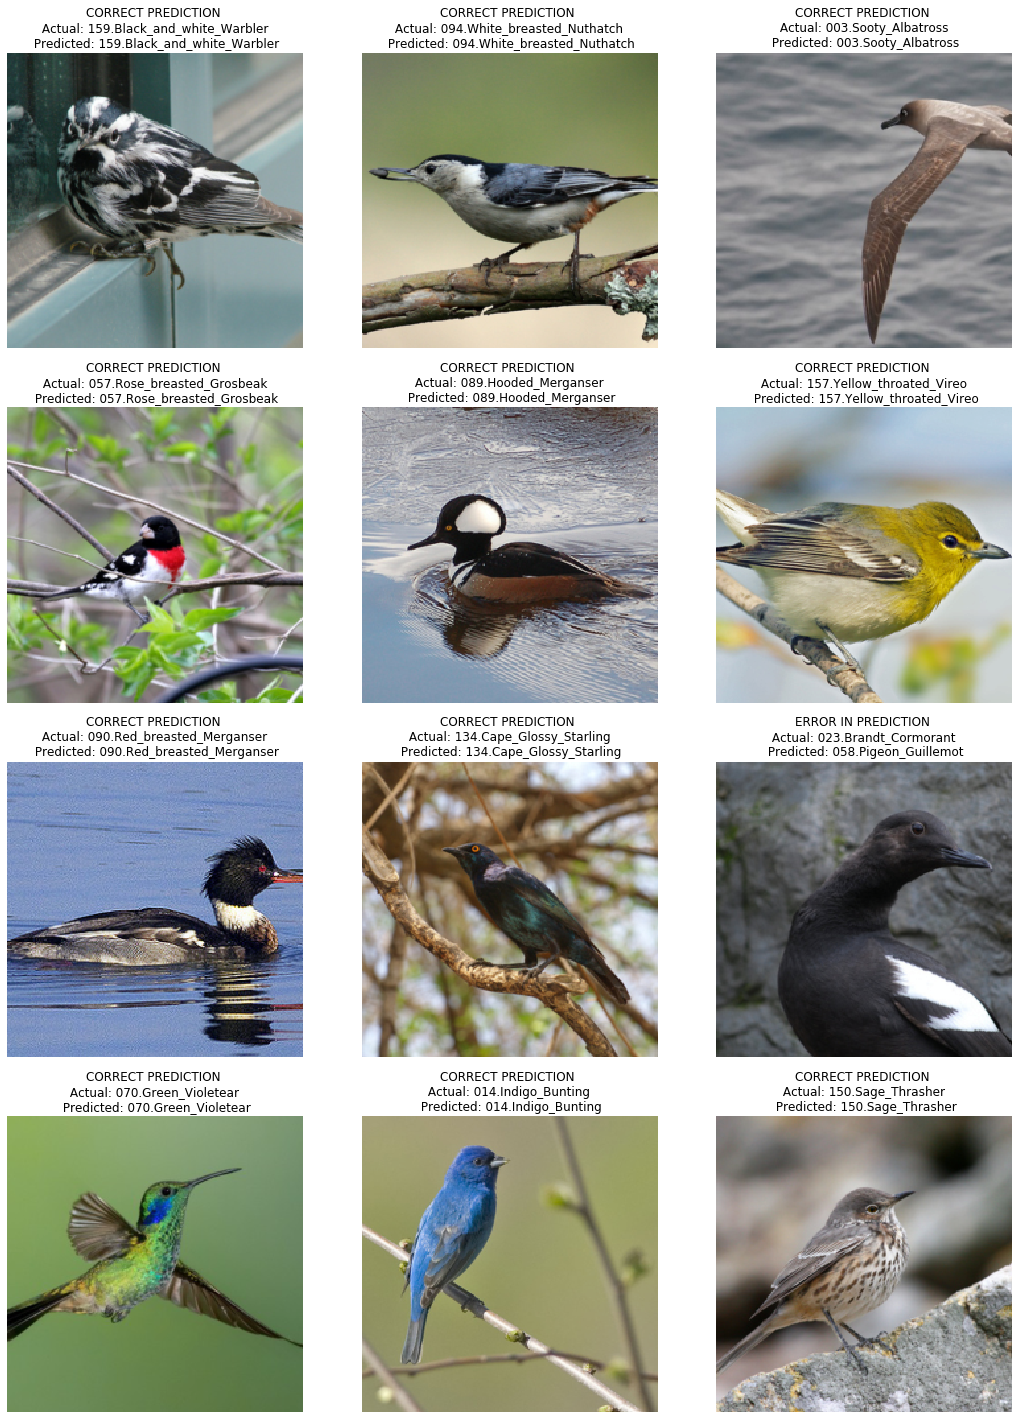

In [121]:
visualize_model_grid(model=model, class_names=class_names, device=device, dataloaders=dataloaders, num_images=12, figsize=(18,25))

In [27]:
results_dict = make_predictions_proba(model=model, dataloaders=dataloaders, device=device)

Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..Complete.


In [123]:
print(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names))

                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.92      0.77      0.84        30
              002.Laysan_Albatross       0.75      0.80      0.77        30
               003.Sooty_Albatross       0.70      1.00      0.82        28
             004.Groove_billed_Ani       0.88      0.93      0.90        30
                005.Crested_Auklet       0.86      0.86      0.86        14
                  006.Least_Auklet       0.91      0.91      0.91        11
               007.Parakeet_Auklet       0.88      0.96      0.92        23
             008.Rhinoceros_Auklet       0.81      0.94      0.87        18
              009.Brewer_Blackbird       0.59      0.59      0.59        29
          010.Red_winged_Blackbird       0.91      0.97      0.94        30
               011.Rusty_Blackbird       0.83      0.67      0.74        30
       012.Yellow_headed_Blackbird       0.90      1.00      0.95        26
           

In [124]:
class_report_df = pd.DataFrame(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names, output_dict=True))
class_report_df

001.Black_footed_Albatross  002.Laysan_Albatross  \
precision                    0.920000              0.750000   
recall                       0.766667              0.800000   
f1-score                     0.836364              0.774194   
support                     30.000000             30.000000   

           003.Sooty_Albatross  004.Groove_billed_Ani  005.Crested_Auklet  \
precision             0.700000               0.875000            0.857143   
recall                1.000000               0.933333            0.857143   
f1-score              0.823529               0.903226            0.857143   
support              28.000000              30.000000           14.000000   

           006.Least_Auklet  007.Parakeet_Auklet  008.Rhinoceros_Auklet  \
precision          0.909091             0.880000               0.809524   
recall             0.909091             0.956522               0.944444   
f1-score           0.909091             0.916667               0.871795   
support           11.000000            23.000000              18.000000   

           009.Brewer_Blackbird  010.Red_winged_Blackbird  ...  \
precision              0.586207                  0.906250  ...   
recall                 0.586207                  0.966667  ...   
f1-score               0.586207                  0.935484  ...   
support               29.000000                 30.000000  ...   

           194.Cactus_Wren  195.Carolina_Wren  196.House_Wren  197.Marsh_Wren  \
precision         0.966667           0.823529        0.863636        0.880000   
recall            0.966667           0.933333        0.633333        0.733333   
f1-score          0.966667           0.875000        0.730769        0.800000   
support          30.000000          30.000000       30.000000       30.000000   

           198.Rock_Wren  199.Winter_Wren  200.Common_Yellowthroat  accuracy  \
precision       0.866667         0.756757                 1.000000  0.842078   
recall          0.866667         0.933333                 0.866667  0.842078   
f1-score        0.866667         0.835821                 0.928571  0.842078   
support        30.000000        30.000000                30.000000  0.842078   

             macro avg  weighted avg  
precision     0.846145      0.846203  
recall        0.843708      0.842078  
f1-score      0.840952      0.840102  
support    5794.000000   5794.000000  

[4 rows x 203 columns]

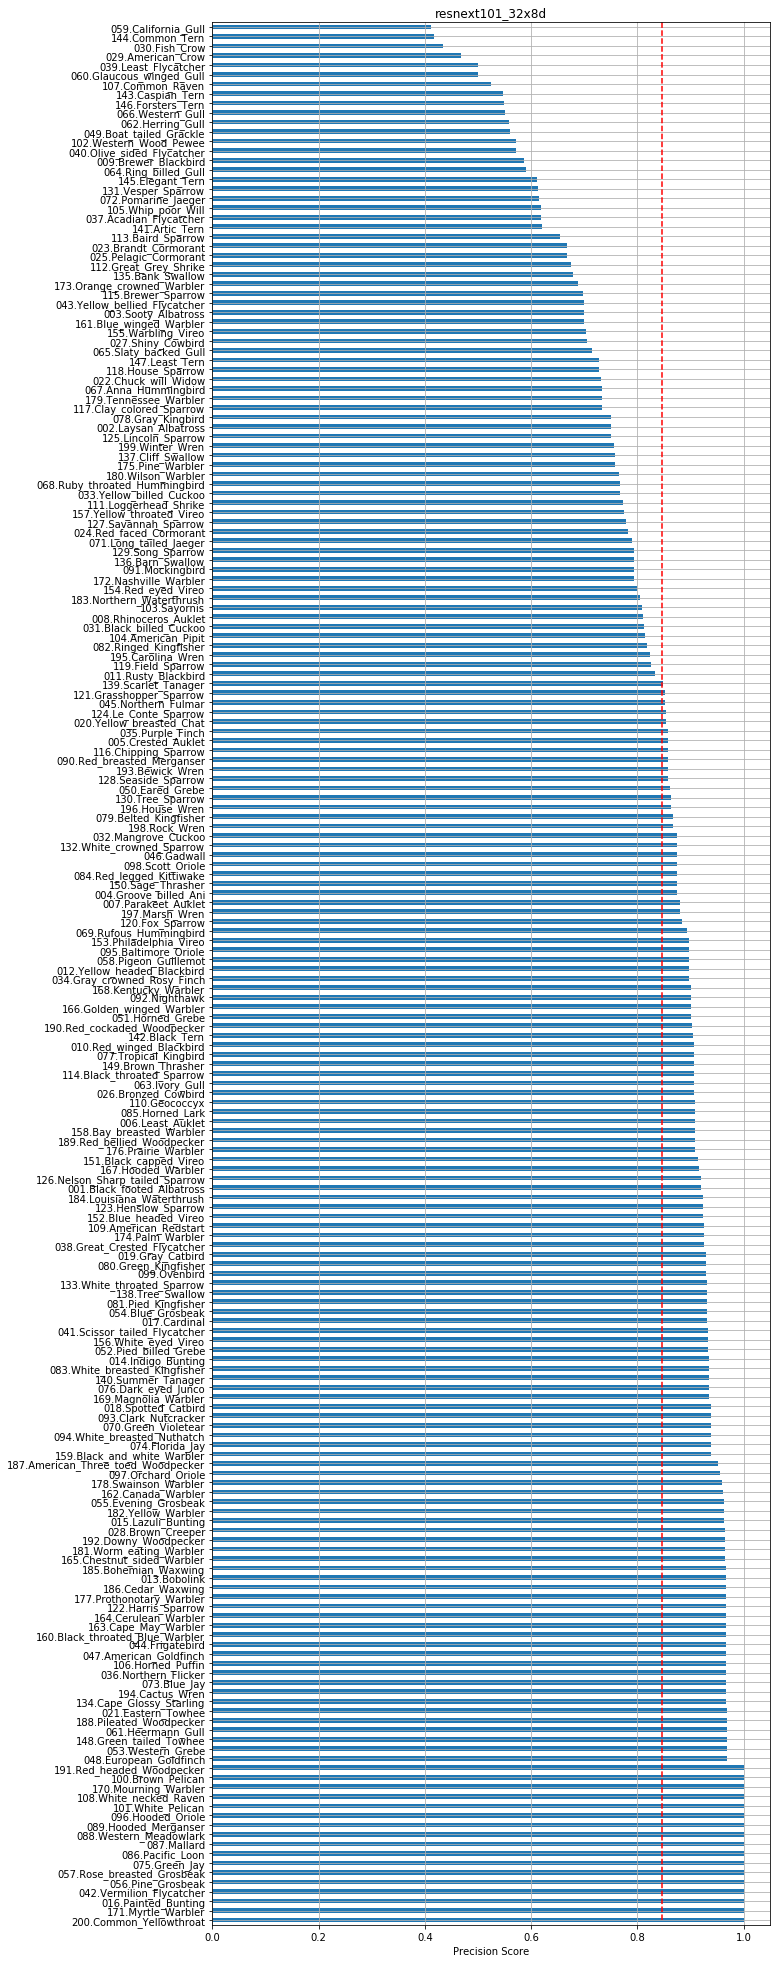

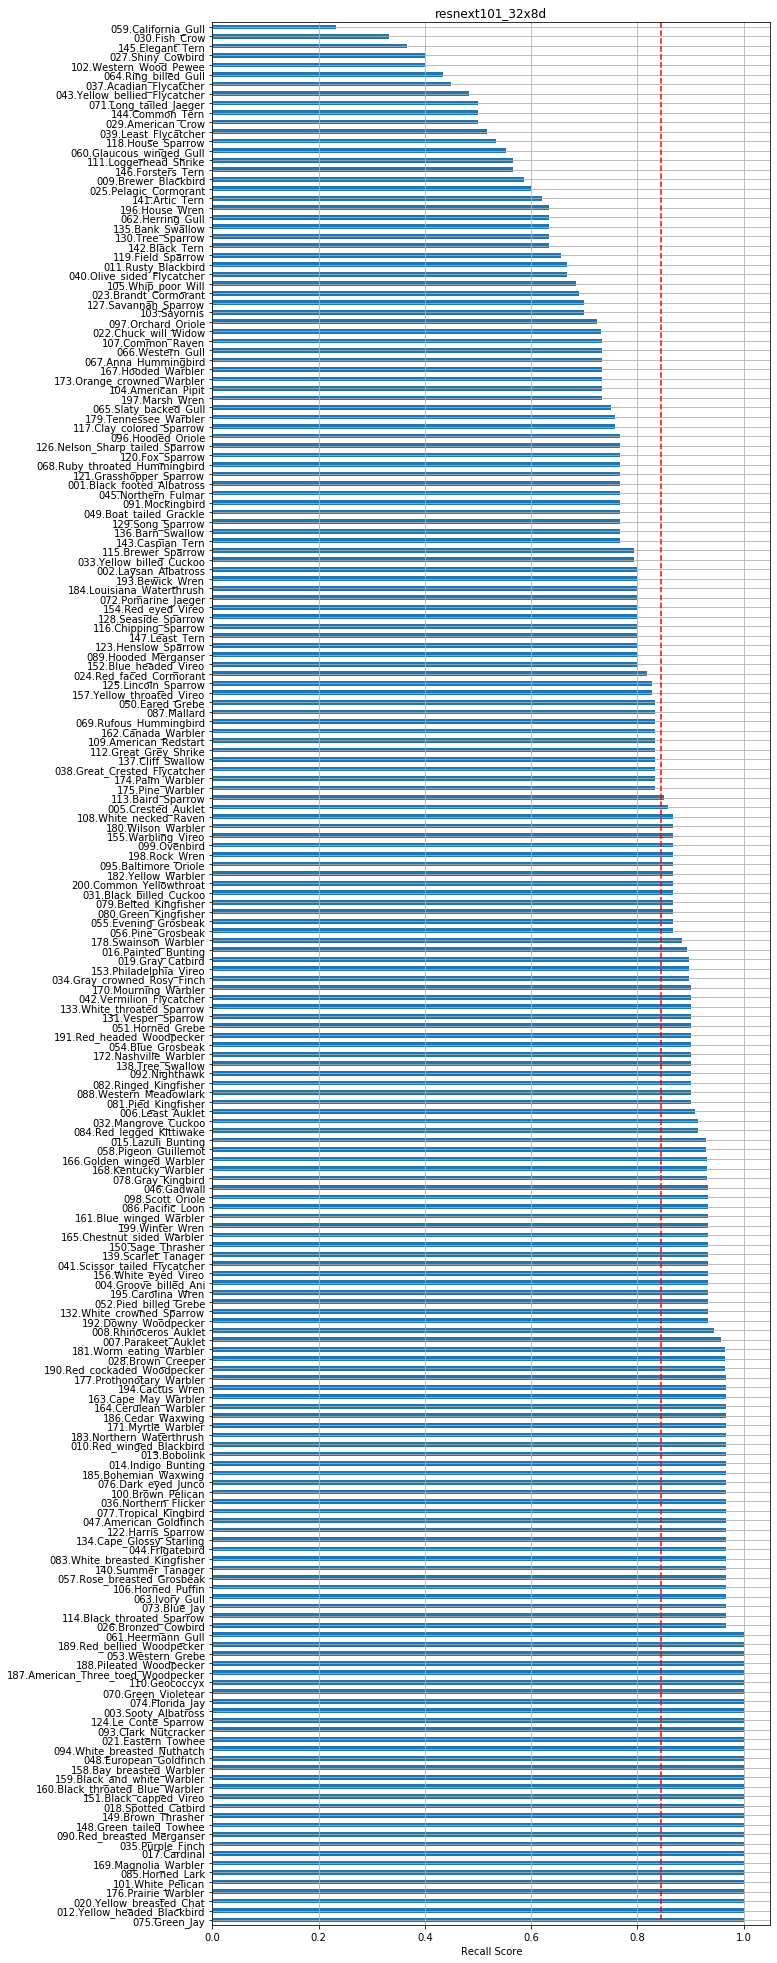

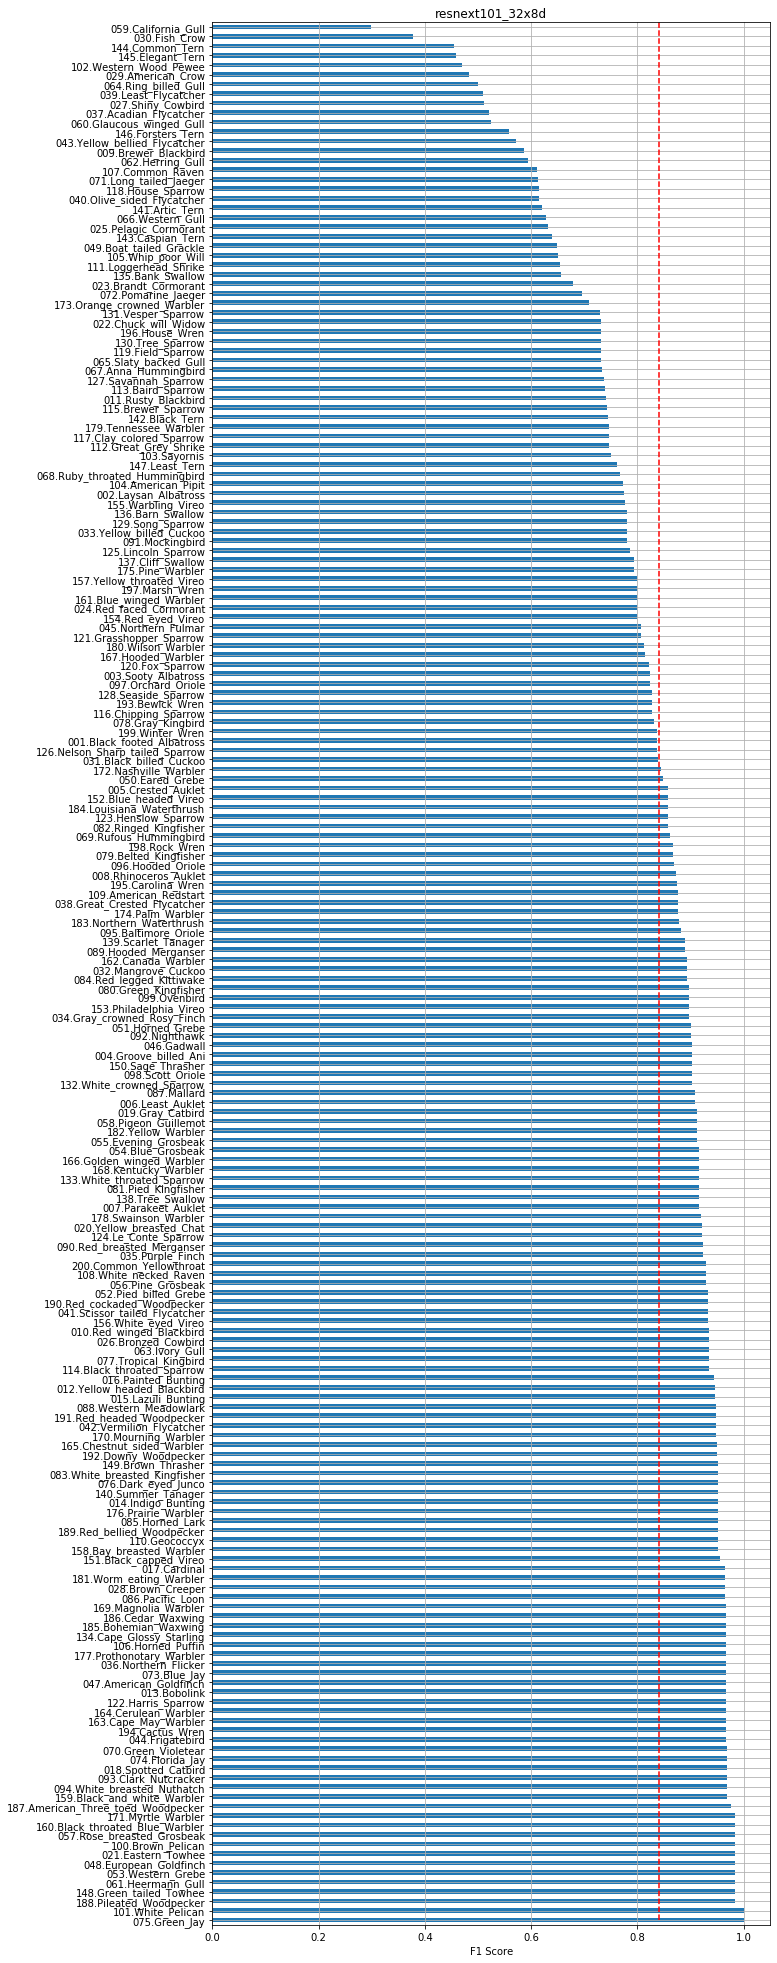

In [125]:
# Full class list metrics

plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['precision']]*2,[0, len(class_names)], 'r--')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model_name)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['recall']]*2, [0, len(class_names)], 'r--')
plt.xlabel('Recall Score')
plt.title(model_name)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['f1-score']]*2, [0, len(class_names)], 'r--')
plt.xlabel('F1 Score')
plt.title(model_name)
plt.grid(True)

plt.show()

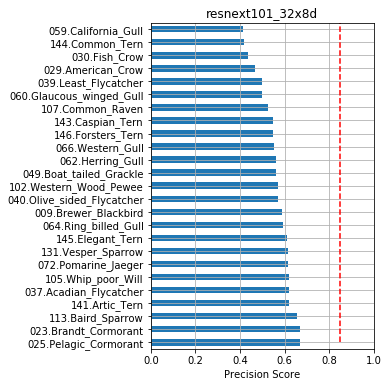

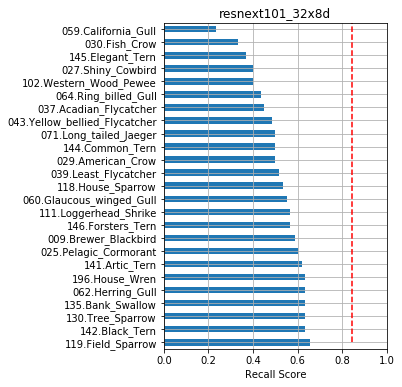

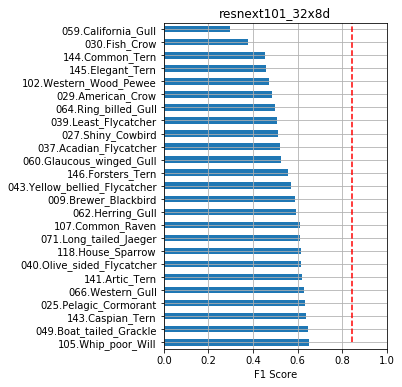

In [90]:
# Worst 25 classes metrics
n_classes = 25
    
plt.figure(figsize=(4,6))
class_report_df.transpose()['precision'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['precision']]*2, [0, n_classes], 'r--')
plt.xlabel('Precision Score')
plt.grid(True)
plt.xlim([0., 1.])
plt.title(model_name)

plt.figure(figsize=(4,6))
class_report_df.transpose()['recall'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['recall']]*2, [0, n_classes], 'r--')
plt.xlabel('Recall Score')
plt.title(model_name)
plt.xlim([0., 1.])
plt.grid(True)

plt.figure(figsize=(4,6))
class_report_df.transpose()['f1-score'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['f1-score']]*2, [0, n_classes], 'r--')
plt.xlabel('F1 Score')
plt.title(model_name)
plt.xlim([0., 1.])
plt.grid(True)

In [126]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred']), index=class_names, columns=class_names)

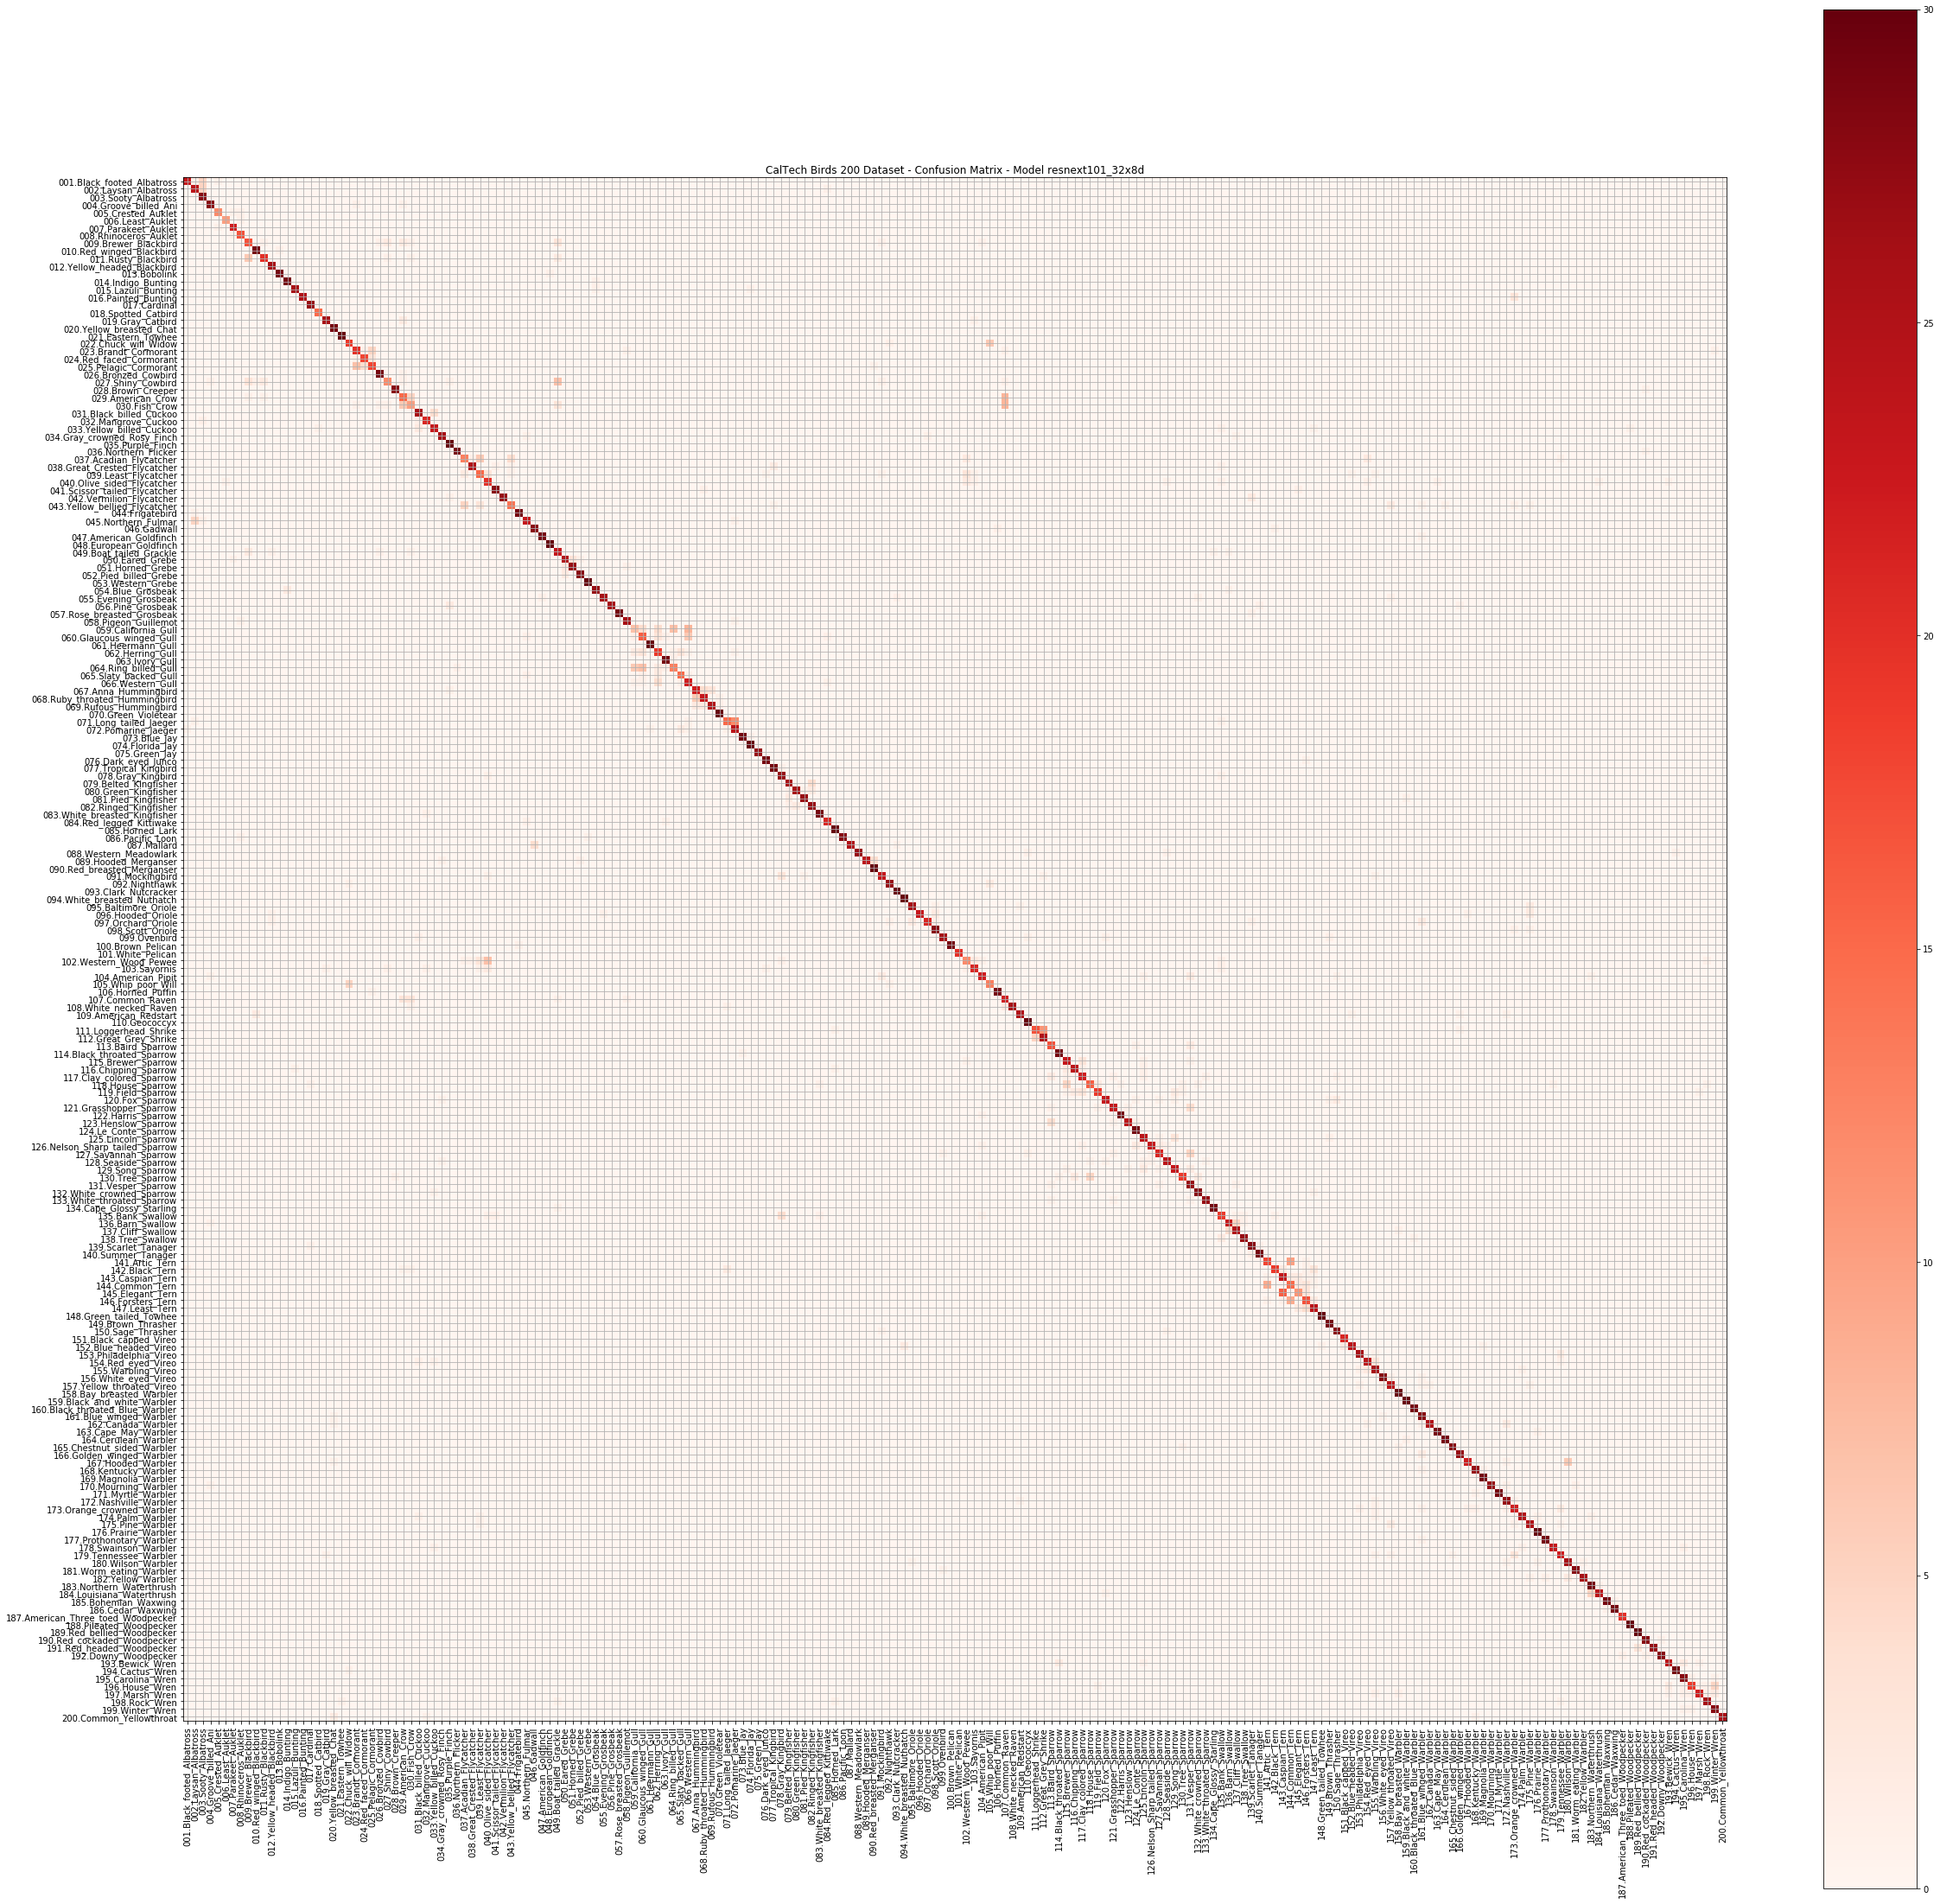

In [127]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model_name))
plt.show()

In [128]:
class_report_df.to_pickle(os.path.join(working_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(working_dir,'confusion_matrix.pkl'))
save_pkl(pkl_object=results_dict, file_name=os.path.join(working_dir,'model_results.pkl'))

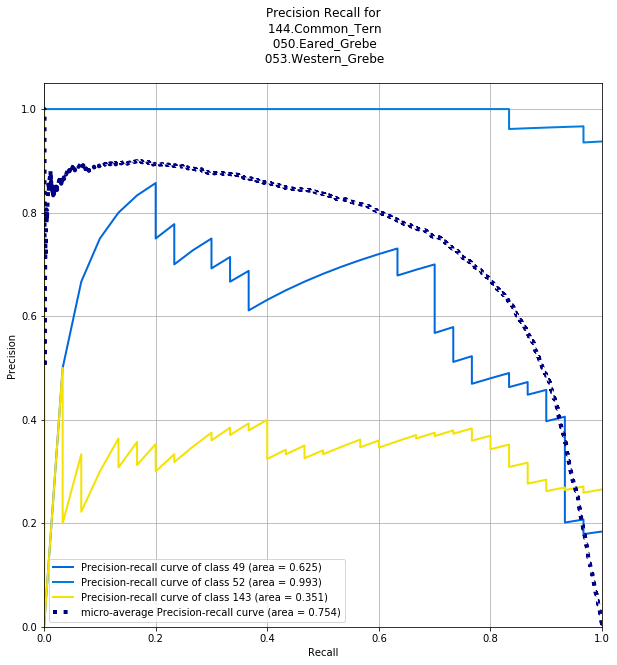

In [129]:
classes_to_plot = [143, 49, 52]
title_str = '\n'
for class_ in classes_to_plot:
    title_str = title_str + ' ' + class_names[class_] +'\n'

plot_precision_recall(y_true=results_dict['labels truth'], y_probas=results_dict['scores pred'], figsize=(10,10), 
                      classes_to_plot=classes_to_plot, title='Precision Recall for'+title_str)
plt.grid(True)
plt.show()

In [130]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [131]:
misclass_scores_df = pd.DataFrame(misclass_scores)
misclass_scores_df

label truth  label pred  \
0            154         153   
1            130         112   
2            117         114   
3            144         142   
4            154         152   
..           ...         ...   
910          120         112   
911           67          66   
912          106          29   
913           32         146   
914          174          38   

                                                scores  
0    [1.4403524e-05, 1.0660202e-05, 6.7299625e-06, ...  
1    [9.752508e-07, 2.0338707e-06, 3.4582438e-06, 8...  
2    [5.839051e-05, 9.939867e-06, 0.0002587971, 0.0...  
3    [6.7640194e-08, 8.926217e-07, 2.9277217e-06, 3...  
4    [1.0267311e-05, 5.170858e-06, 8.785369e-06, 7....  
..                                                 ...  
910  [1.0039127e-05, 4.2175175e-06, 8.229633e-06, 1...  
911  [1.5104577e-08, 2.6632625e-08, 2.72516e-07, 5....  
912  [5.296426e-06, 7.2457306e-06, 3.2019968e-06, 0...  
913  [2.6839532e-05, 0.0001478827, 3.1270585e-05, 8...  
914  [1.2017179e-06, 1.2252484e-06, 8.1420485e-06, ...  

[915 rows x 3 columns]

In [132]:
print('   MISCLASSIFICATION SUMMARY of CUB-200-2011 Test Set    ')
print('CNN Model:: {}'.format(model_name))
print('')
misclass_summary = {}
misclass_summary['number of misclasses'] = {}
misclass_summary['misclass classes'] = {}
for class_ in np.sort(misclass_scores_df['label truth'].unique()):
    misclass_summary['number of misclasses'][class_names[class_]] = (misclass_scores_df['label truth'] == class_).sum()
    
    misclass_summary['misclass classes'][class_names[class_]] = {'class':[], 'count':[]}
    str = 'Class:: {} :: '.format(class_names[class_])
    for misclass_class in misclass_scores_df['label pred'][misclass_scores_df['label truth'] == class_].unique():
        str = str + '\n \t \t \t {} ({}) '.format(class_names[misclass_class], (misclass_scores_df['label pred'][misclass_scores_df['label truth'] == class_] == misclass_class).sum())
        misclass_summary['misclass classes'][class_names[class_]]['class'].append(class_names[misclass_class])
        misclass_summary['misclass classes'][class_names[class_]]['count'].append((misclass_scores_df['label pred'][misclass_scores_df['label truth'] == class_] == misclass_class).sum())
    print(str)

   MISCLASSIFICATION SUMMARY of CUB-200-2011 Test Set    
CNN Model:: resnext101_32x8d

Class:: 001.Black_footed_Albatross :: 
 	 	 	 003.Sooty_Albatross (5) 
 	 	 	 005.Crested_Auklet (1) 
 	 	 	 002.Laysan_Albatross (1) 
Class:: 002.Laysan_Albatross :: 
 	 	 	 003.Sooty_Albatross (5) 
 	 	 	 084.Red_legged_Kittiwake (1) 
Class:: 004.Groove_billed_Ani :: 
 	 	 	 023.Brandt_Cormorant (1) 
 	 	 	 029.American_Crow (1) 
Class:: 005.Crested_Auklet :: 
 	 	 	 007.Parakeet_Auklet (1) 
 	 	 	 008.Rhinoceros_Auklet (1) 
Class:: 006.Least_Auklet :: 
 	 	 	 008.Rhinoceros_Auklet (1) 
Class:: 007.Parakeet_Auklet :: 
 	 	 	 005.Crested_Auklet (1) 
Class:: 008.Rhinoceros_Auklet :: 
 	 	 	 007.Parakeet_Auklet (1) 
Class:: 009.Brewer_Blackbird :: 
 	 	 	 049.Boat_tailed_Grackle (3) 
 	 	 	 091.Mockingbird (1) 
 	 	 	 027.Shiny_Cowbird (2) 
 	 	 	 029.American_Crow (2) 
 	 	 	 026.Bronzed_Cowbird (1) 
 	 	 	 030.Fish_Crow (1) 
 	 	 	 104.American_Pipit (1) 
 	 	 	 011.Rusty_Blackbird (1) 
Class:: 010

 	 	 	 098.Scott_Oriole (1) 
Class:: 096.Hooded_Oriole :: 
 	 	 	 098.Scott_Oriole (2) 
 	 	 	 175.Pine_Warbler (2) 
 	 	 	 055.Evening_Grosbeak (1) 
 	 	 	 012.Yellow_headed_Blackbird (1) 
 	 	 	 167.Hooded_Warbler (1) 
Class:: 097.Orchard_Oriole :: 
 	 	 	 098.Scott_Oriole (1) 
 	 	 	 161.Blue_winged_Warbler (2) 
 	 	 	 092.Nighthawk (1) 
 	 	 	 095.Baltimore_Oriole (2) 
 	 	 	 139.Scarlet_Tanager (1) 
 	 	 	 012.Yellow_headed_Blackbird (1) 
Class:: 098.Scott_Oriole :: 
 	 	 	 175.Pine_Warbler (1) 
 	 	 	 173.Orange_crowned_Warbler (1) 
Class:: 099.Ovenbird :: 
 	 	 	 149.Brown_Thrasher (1) 
 	 	 	 110.Geococcyx (1) 
 	 	 	 031.Black_billed_Cuckoo (1) 
 	 	 	 120.Fox_Sparrow (1) 
Class:: 100.Brown_Pelican :: 
 	 	 	 044.Frigatebird (1) 
Class:: 102.Western_Wood_Pewee :: 
 	 	 	 039.Least_Flycatcher (3) 
 	 	 	 040.Olive_sided_Flycatcher (7) 
 	 	 	 198.Rock_Wren (1) 
 	 	 	 135.Bank_Swallow (1) 
 	 	 	 038.Great_Crested_Flycatcher (1) 
 	 	 	 104.American_Pipit (1) 
 	 	 	 078.Gray_K

 	 	 	 161.Blue_winged_Warbler (1) 
Class:: 161.Blue_winged_Warbler :: 
 	 	 	 020.Yellow_breasted_Chat (1) 
 	 	 	 156.White_eyed_Vireo (1) 
Class:: 162.Canada_Warbler :: 
 	 	 	 161.Blue_winged_Warbler (1) 
 	 	 	 154.Red_eyed_Vireo (1) 
 	 	 	 020.Yellow_breasted_Chat (1) 
 	 	 	 172.Nashville_Warbler (2) 
Class:: 163.Cape_May_Warbler :: 
 	 	 	 176.Prairie_Warbler (1) 
Class:: 164.Cerulean_Warbler :: 
 	 	 	 159.Black_and_white_Warbler (1) 
Class:: 165.Chestnut_sided_Warbler :: 
 	 	 	 130.Tree_Sparrow (1) 
 	 	 	 158.Bay_breasted_Warbler (1) 
Class:: 166.Golden_winged_Warbler :: 
 	 	 	 161.Blue_winged_Warbler (2) 
Class:: 167.Hooded_Warbler :: 
 	 	 	 020.Yellow_breasted_Chat (1) 
 	 	 	 180.Wilson_Warbler (6) 
 	 	 	 172.Nashville_Warbler (1) 
Class:: 168.Kentucky_Warbler :: 
 	 	 	 161.Blue_winged_Warbler (1) 
 	 	 	 169.Magnolia_Warbler (1) 
Class:: 170.Mourning_Warbler :: 
 	 	 	 172.Nashville_Warbler (1) 
 	 	 	 004.Groove_billed_Ani (1) 
 	 	 	 181.Worm_eating_Warbler (1) 


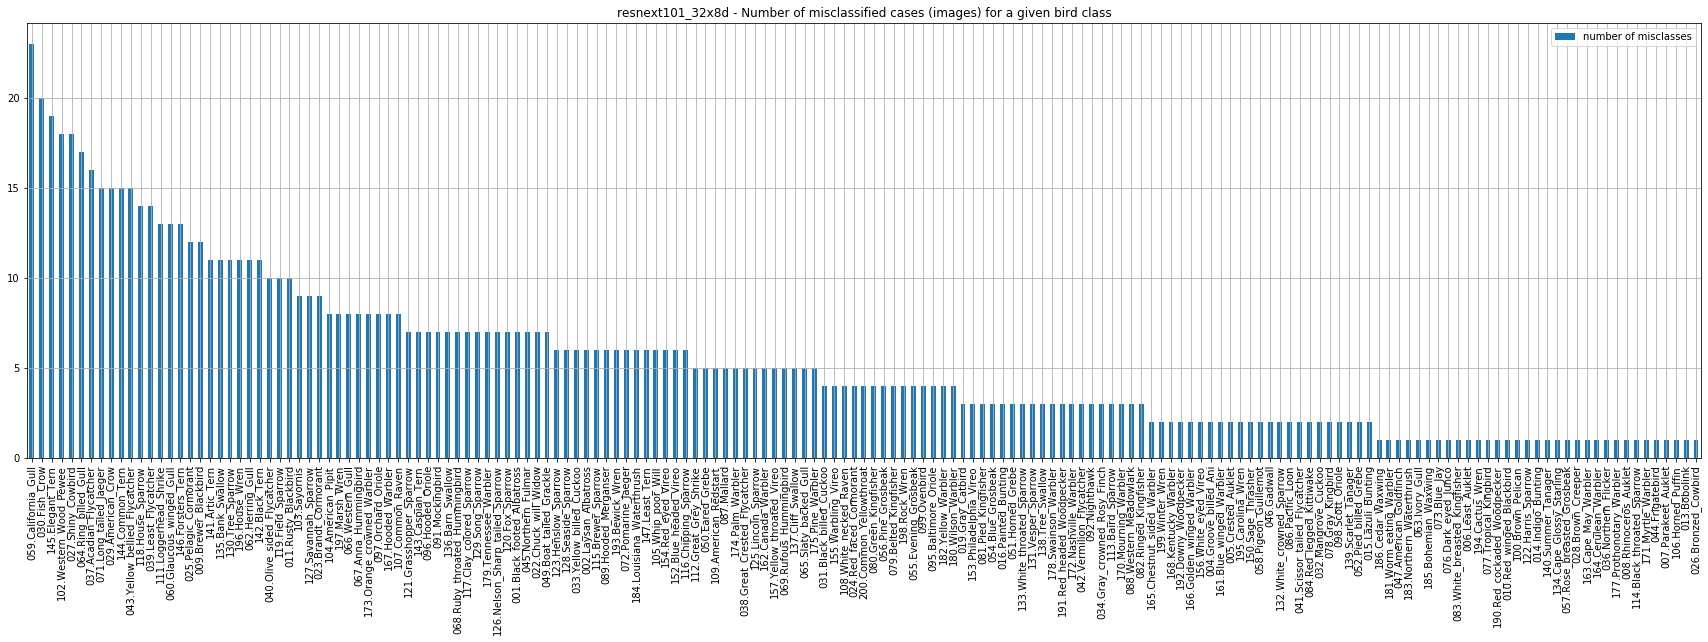

In [133]:
pd.DataFrame(misclass_summary).sort_values(by=['number of misclasses'], ascending=False).plot(kind='bar', figsize=(30,8))
plt.grid(True)

plt.title(model_name+' - Number of misclassified cases (images) for a given bird class')
plt.show()

C:\Users\leeez\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


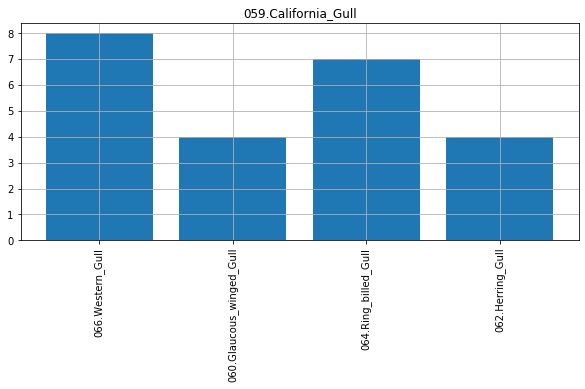

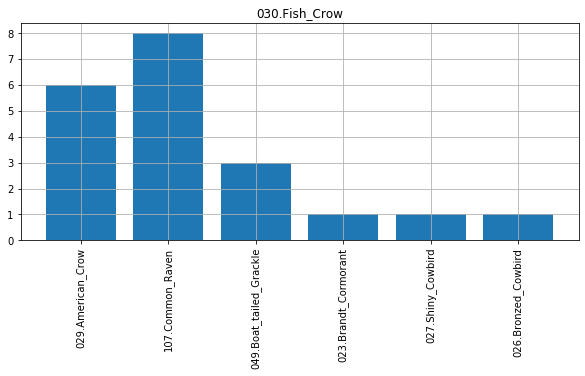

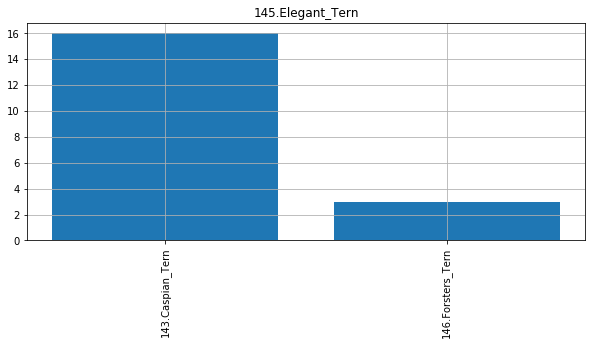

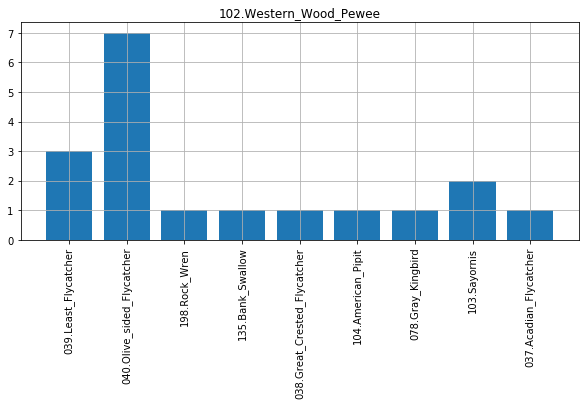

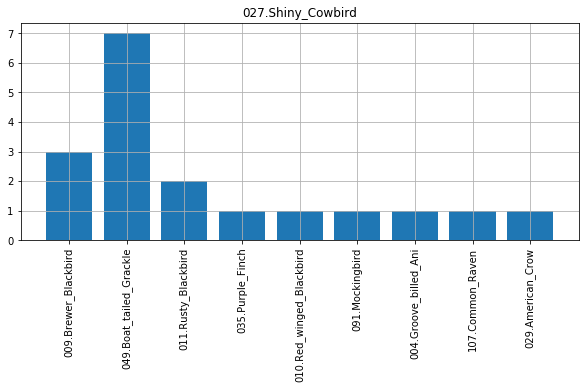

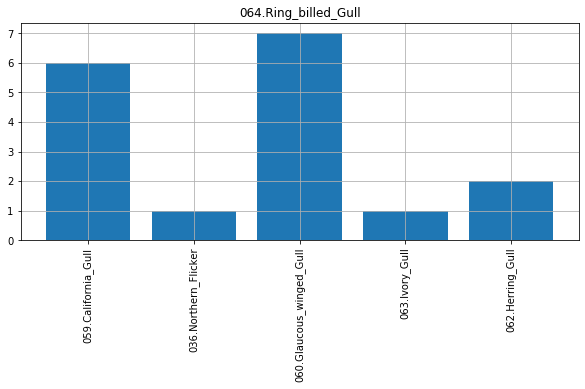

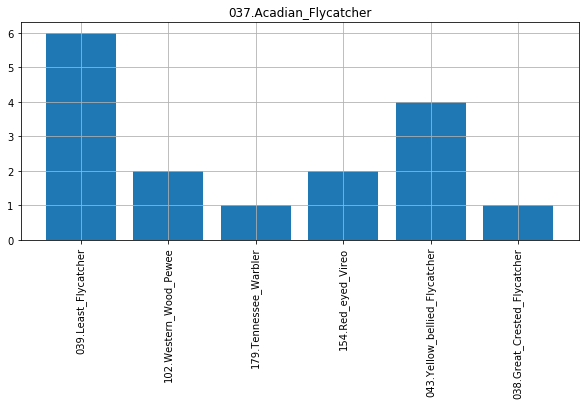

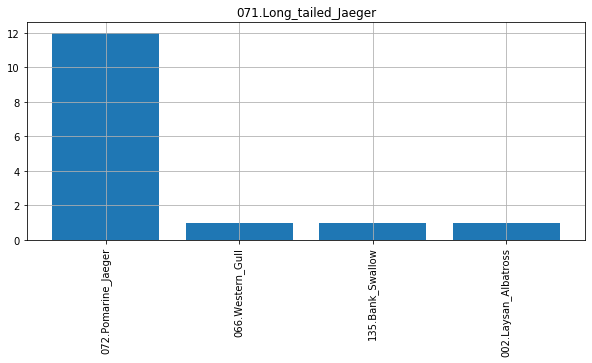

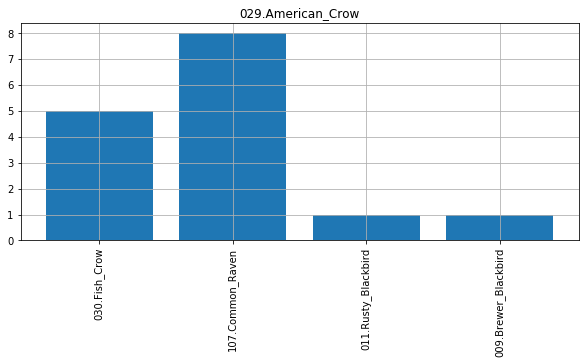

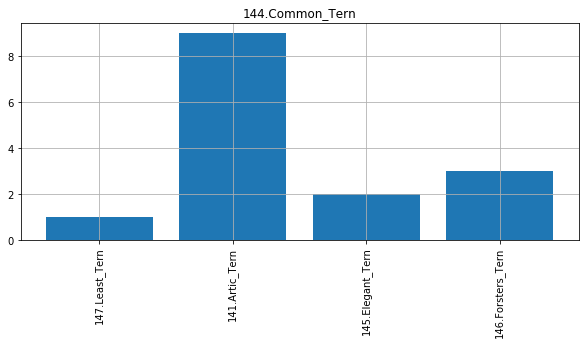

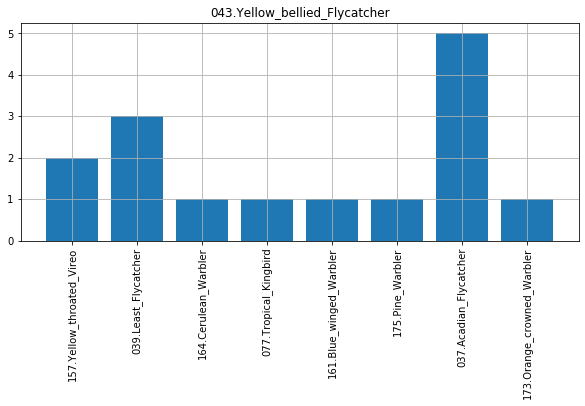

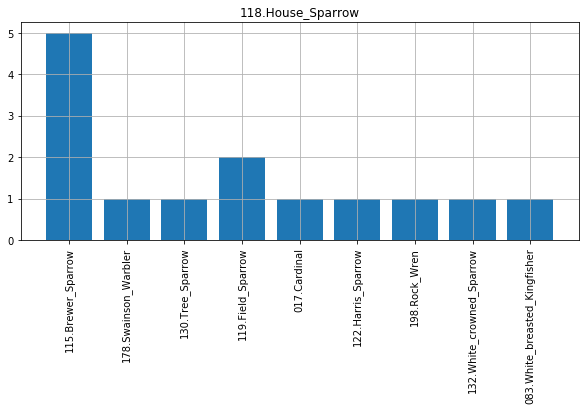

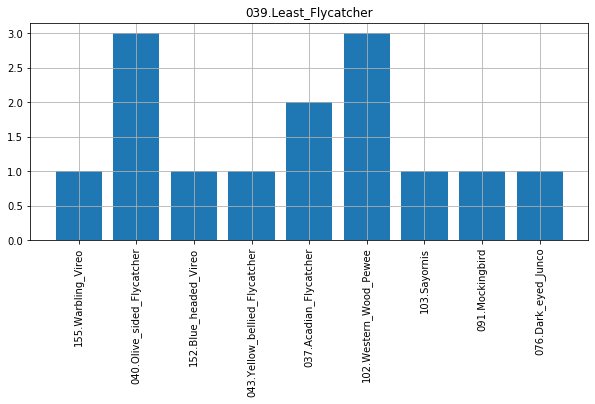

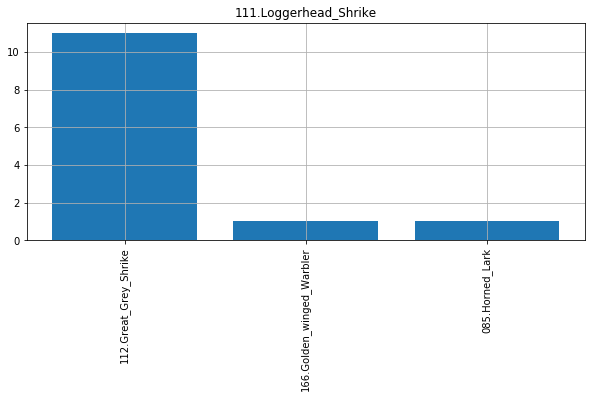

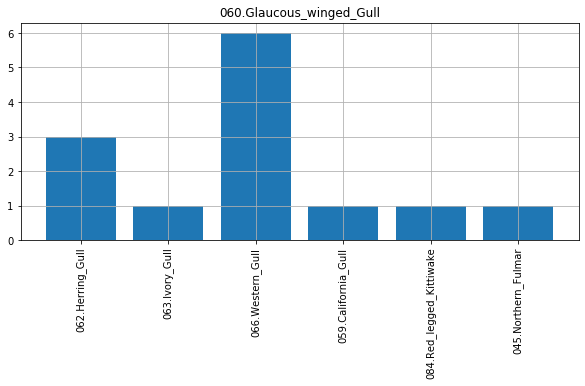

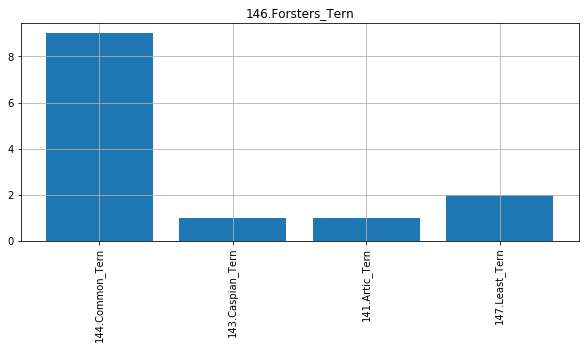

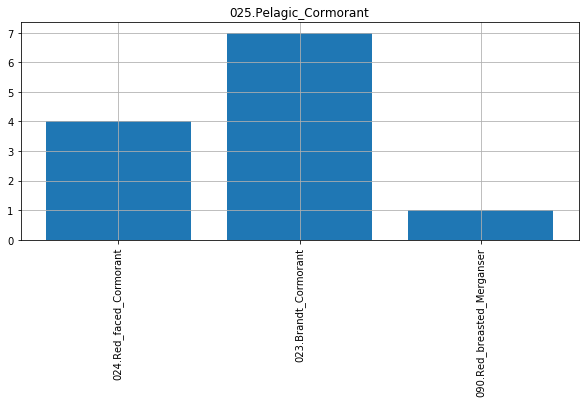

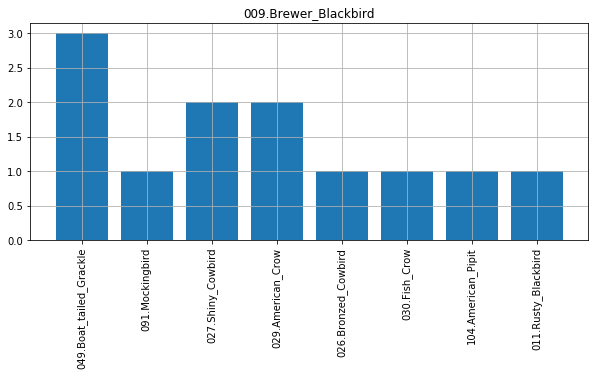

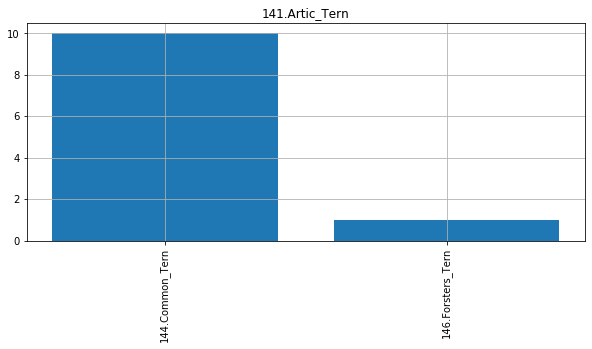

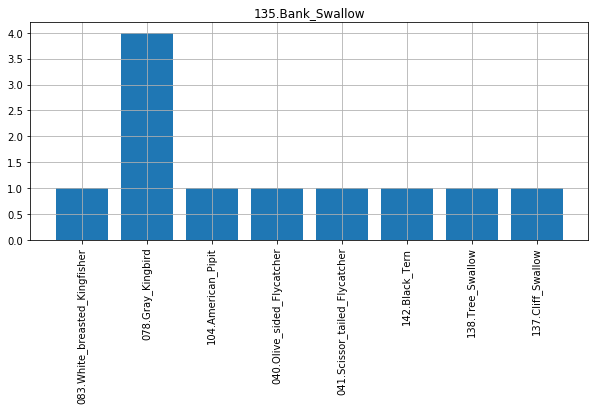

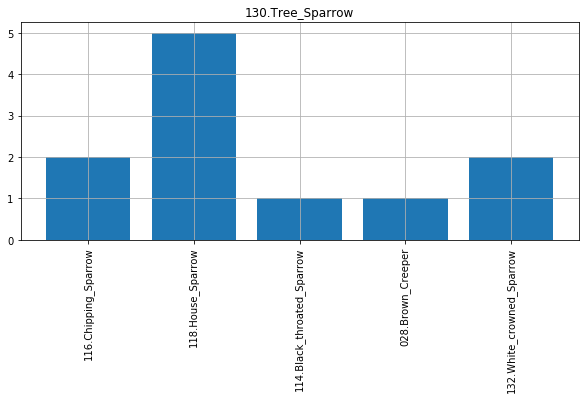

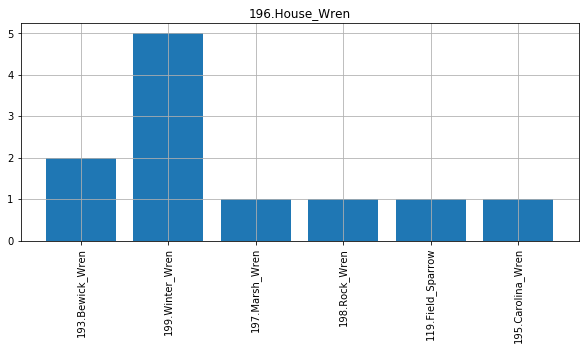

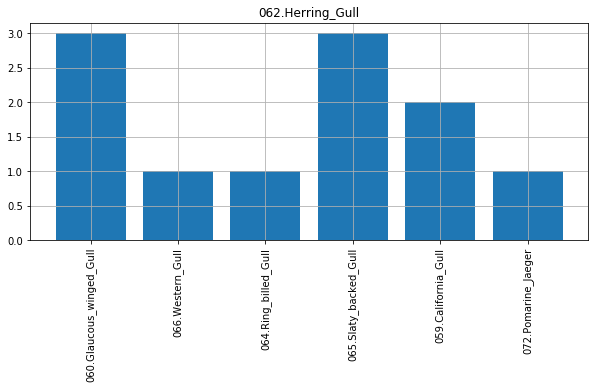

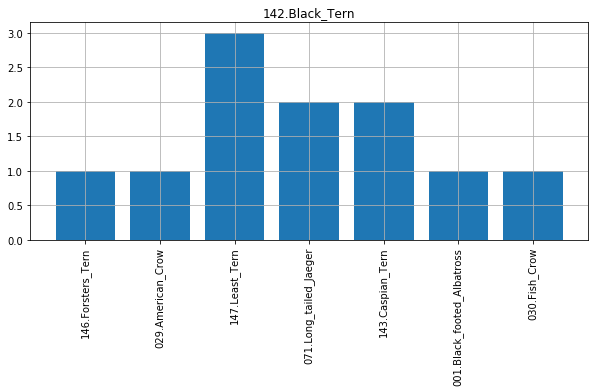

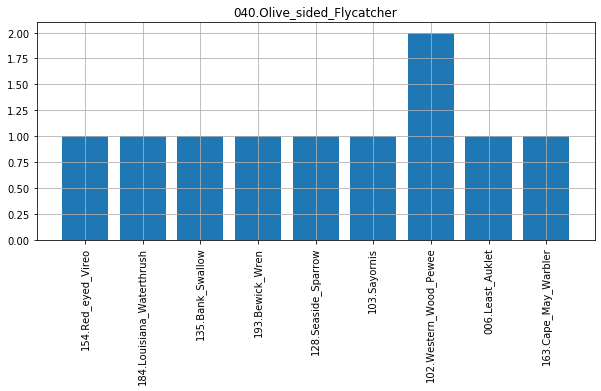

In [134]:
sorted_misclass_index = pd.DataFrame(misclass_summary).sort_values(by=['number of misclasses'], ascending=False).index.to_list()

for class_ in sorted_misclass_index[0:25]:
    plt.figure(figsize=(10,4))
    plt.bar(x=misclass_summary['misclass classes'][class_]['class'], 
            height=misclass_summary['misclass classes'][class_]['count'])
    plt.title(class_)
    plt.grid(True)
    plt.xticks(rotation=90)
plt.show()

In [135]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)
class_id = 61
print('Selected Class {}'.format(class_names[class_id]))

Selected Class 062.Herring_Gull


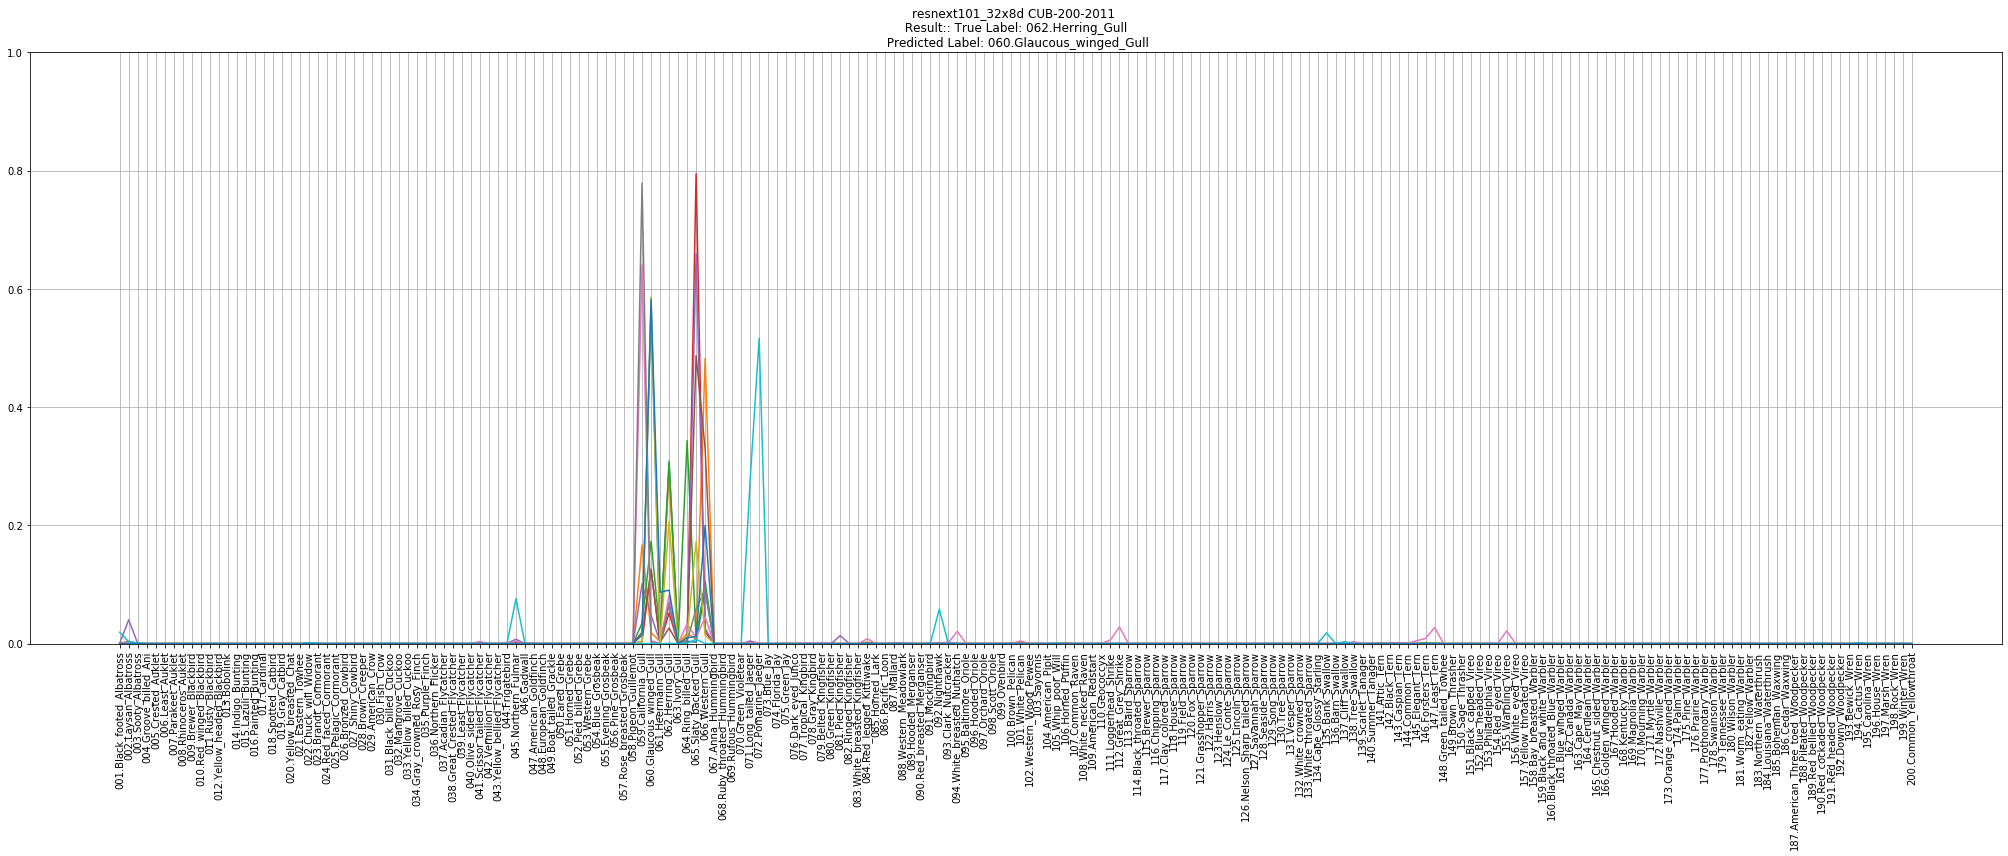

In [136]:
plt.figure(figsize=(28,12))
for i, scores in misclass_scores_df['scores'][(misclass_scores_df['label truth'] == class_id)].items():
    sns.lineplot(x=class_names,y=scores)
    plt.xticks(rotation=90)
    plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model_name, class_names[misclass_scores_df['label truth'][i]], class_names[misclass_scores_df['label pred'][i]]))
    plt.grid(True)
    plt.tight_layout()
    plt.ylim([0.0, 1.0])
plt.show()

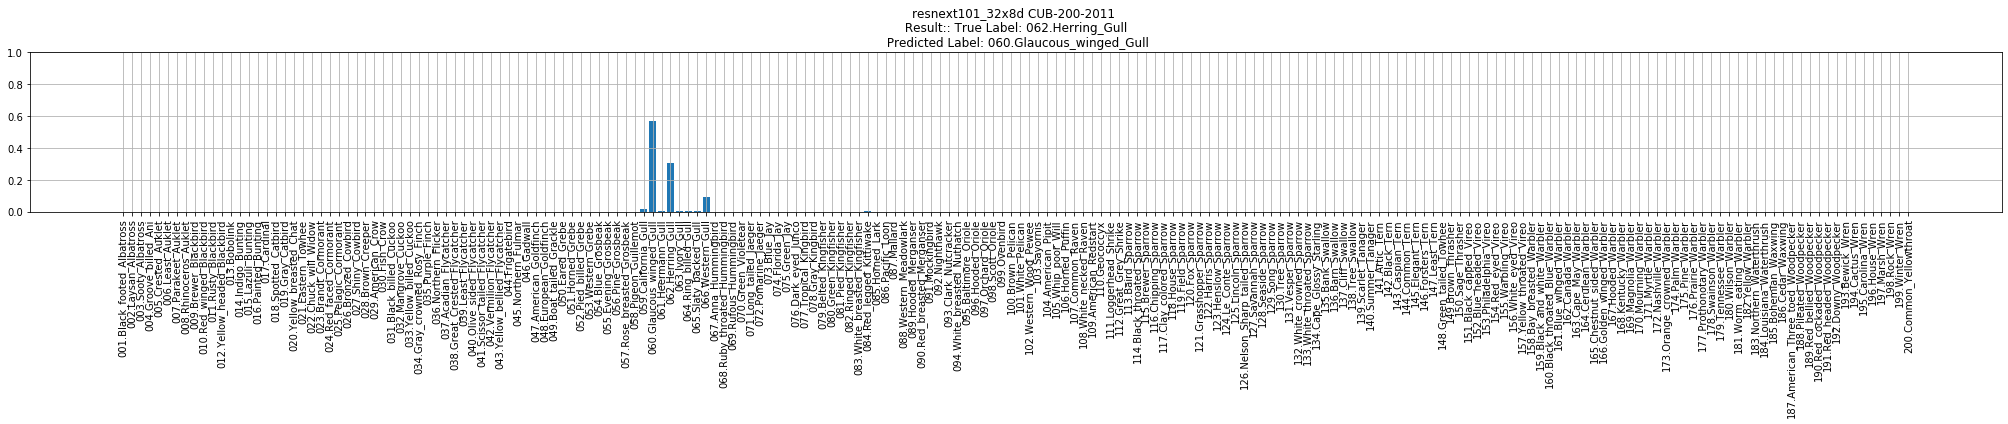

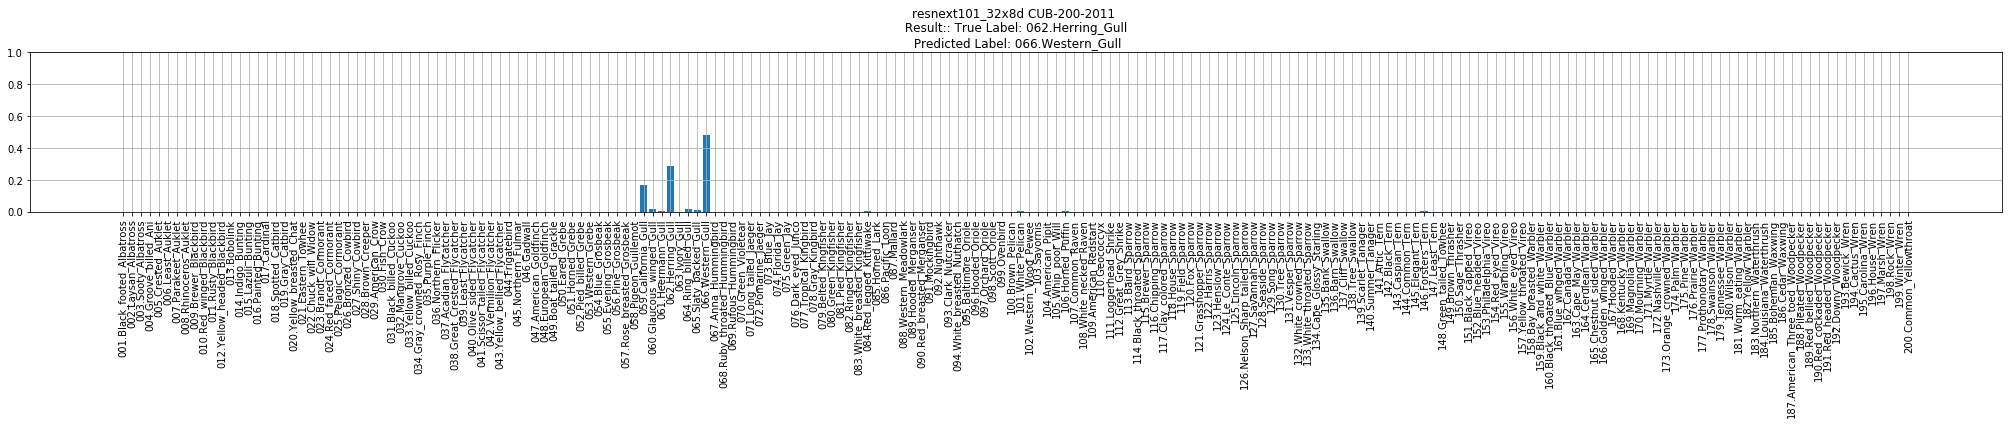

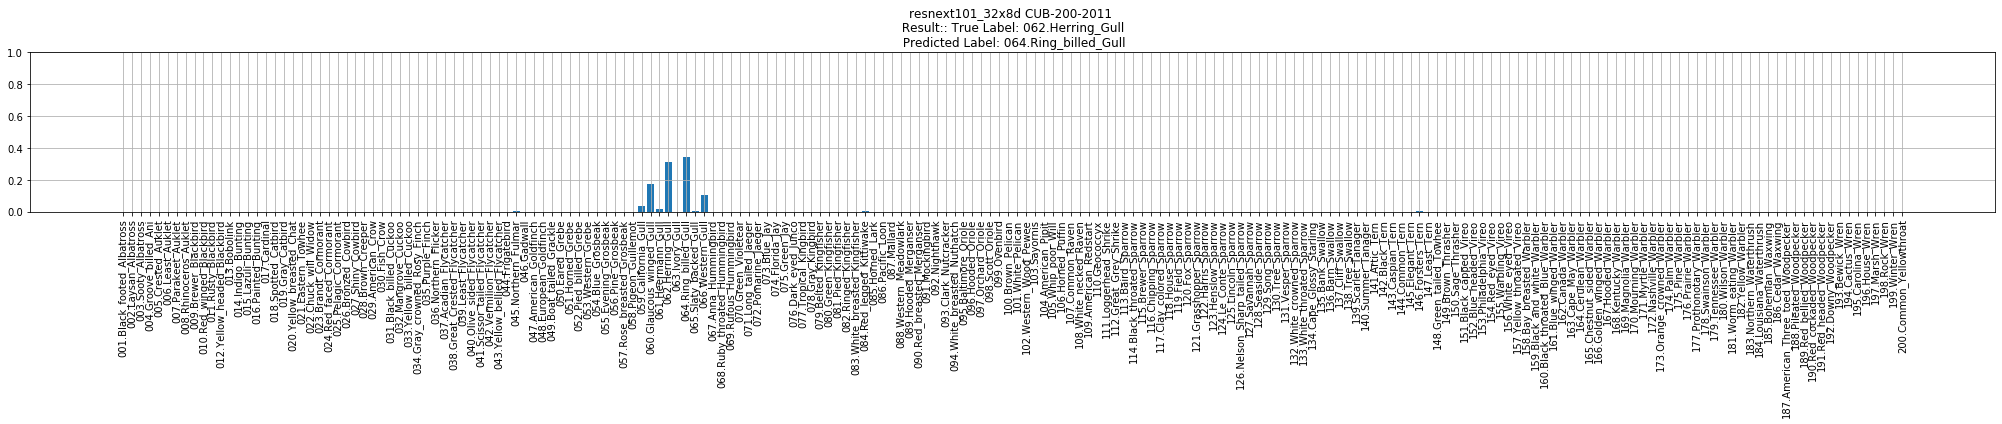

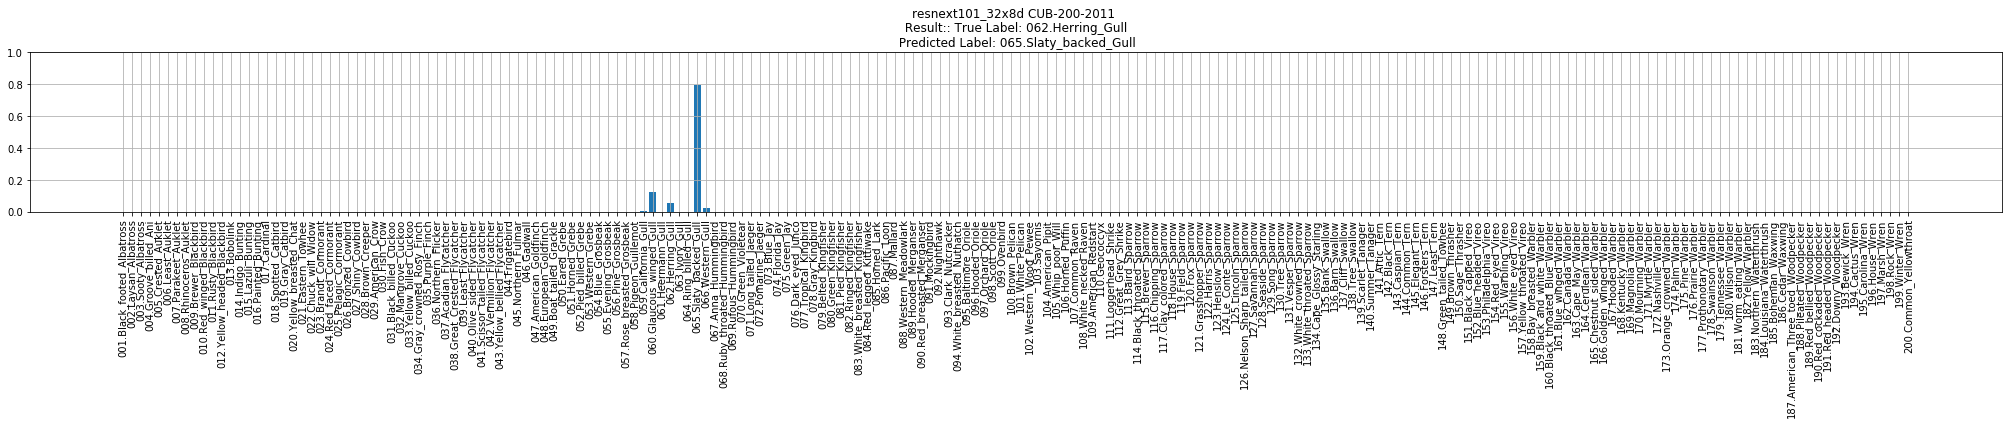

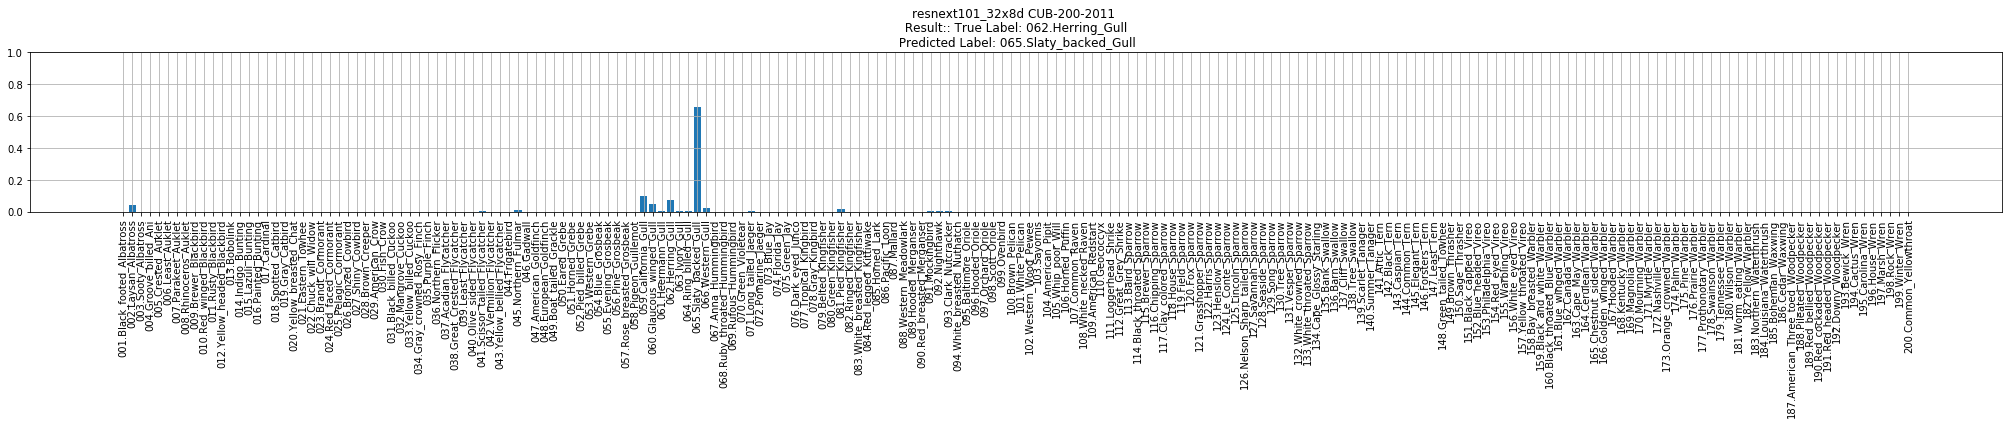

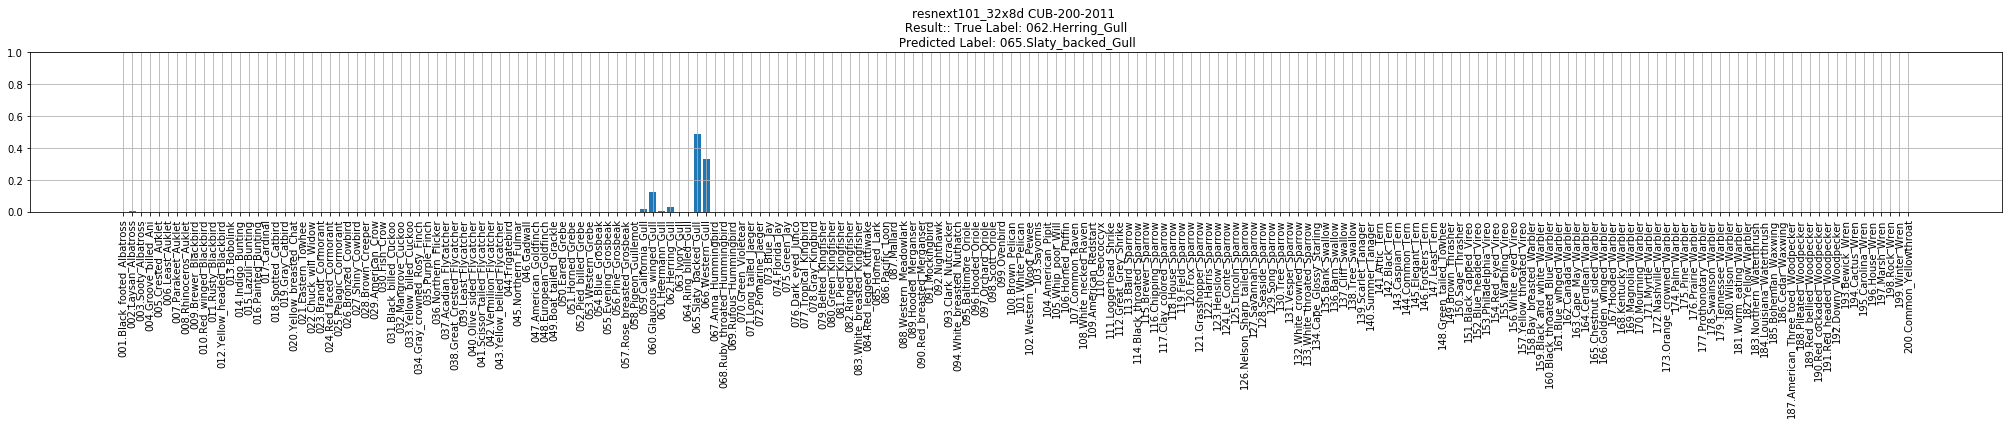

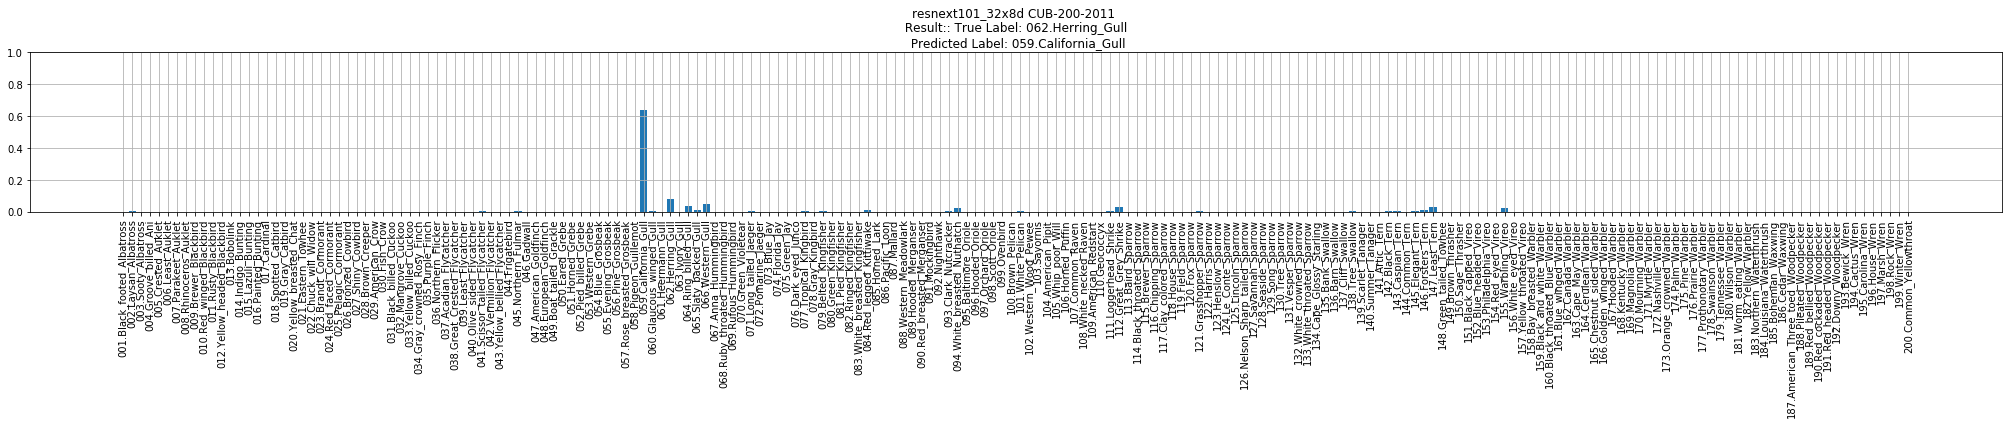

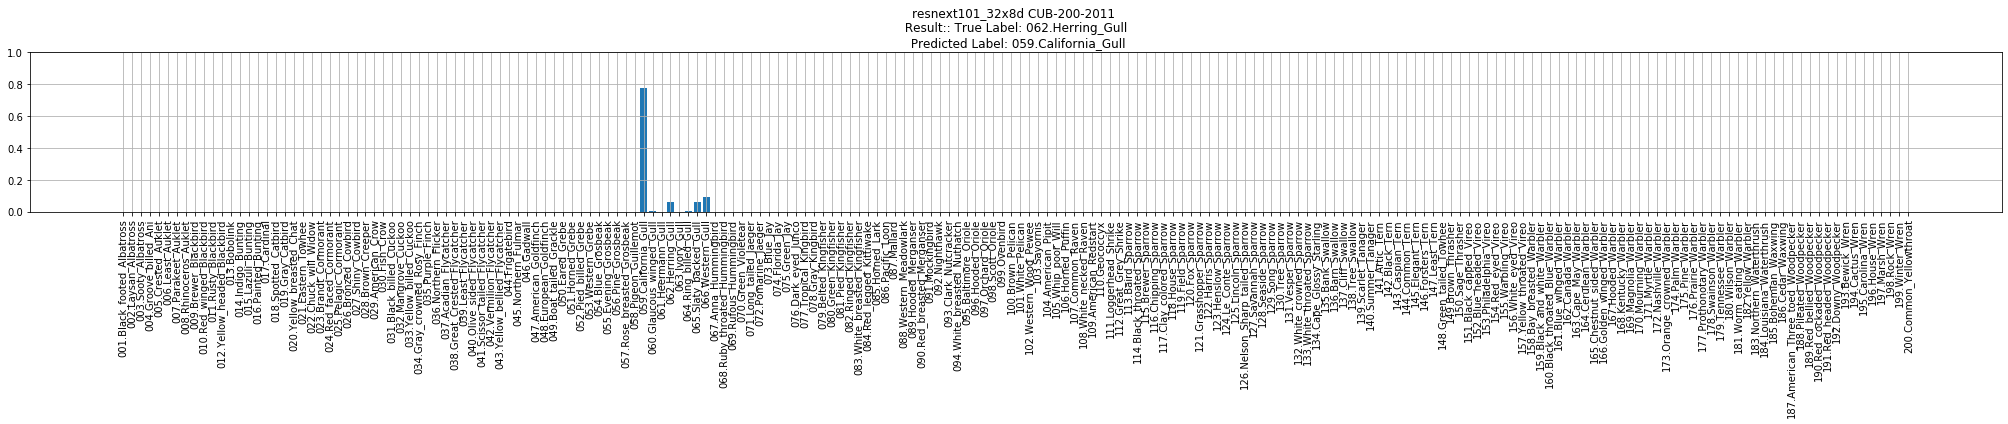

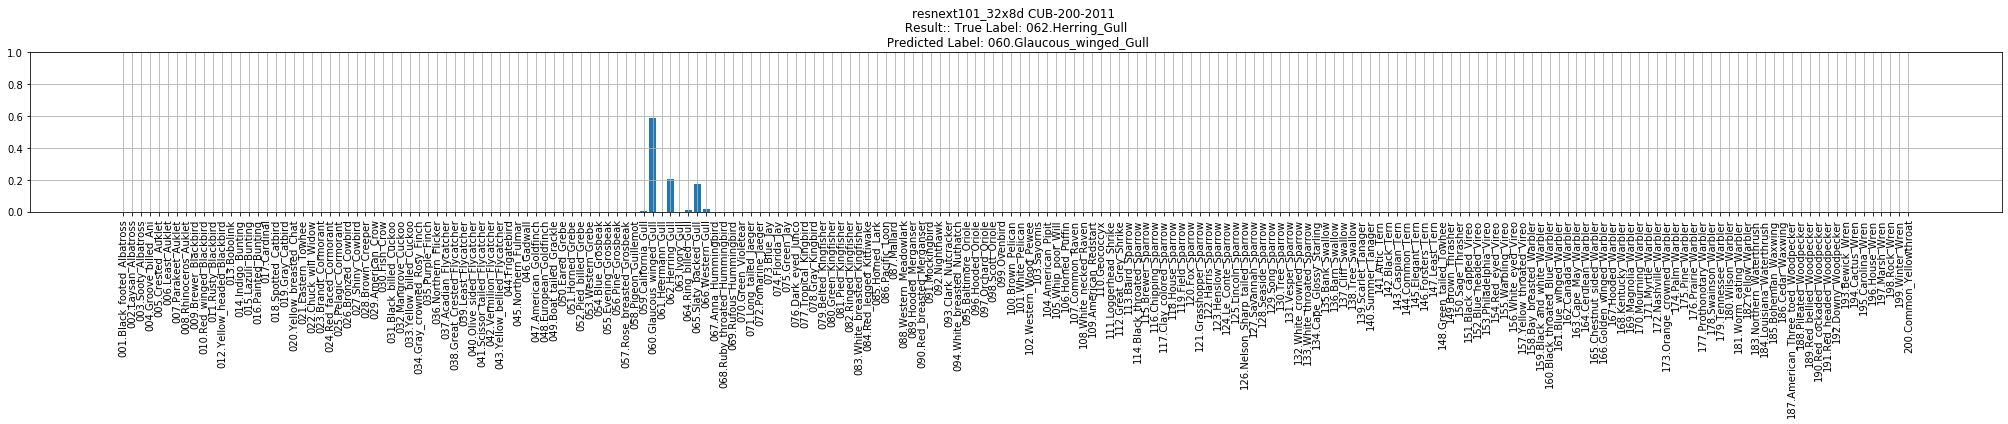

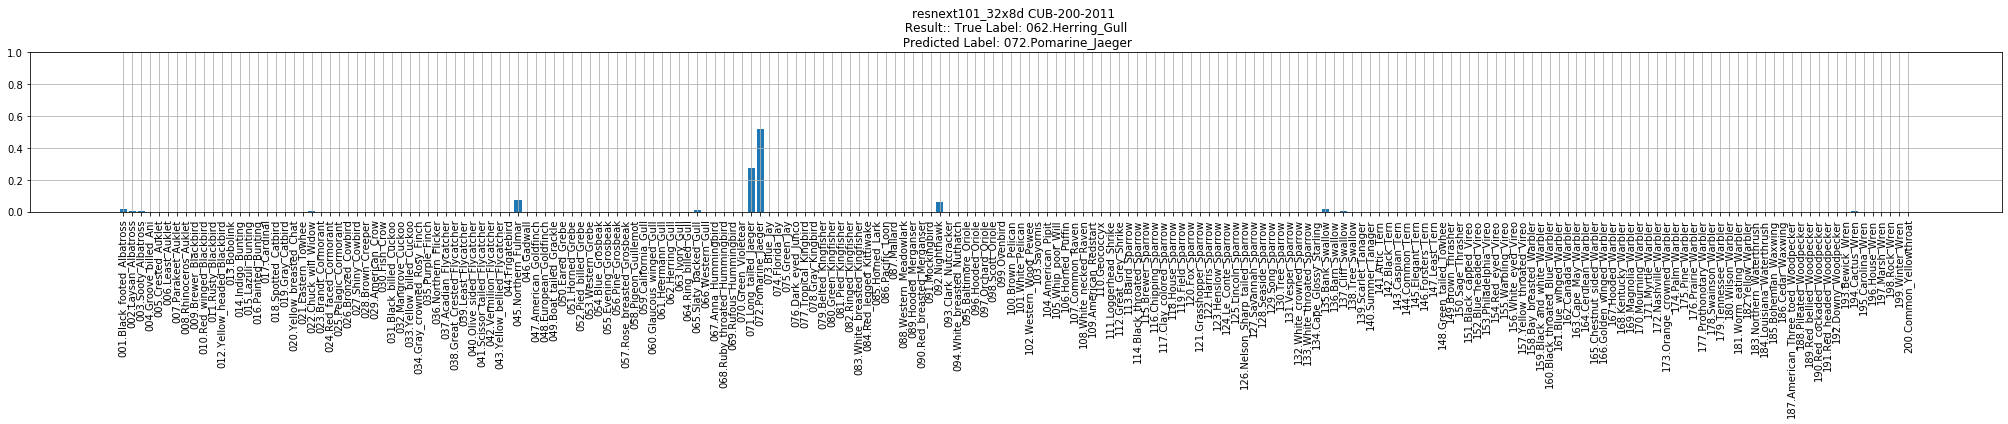

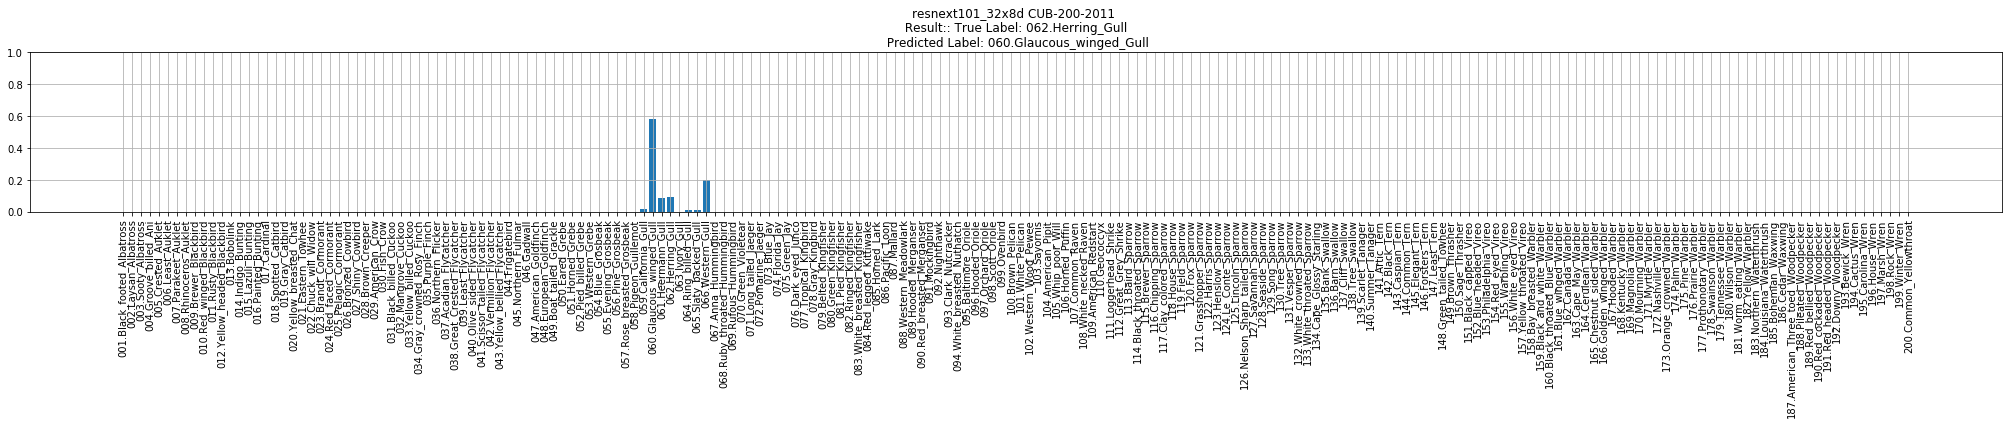

In [137]:
for i, scores in misclass_scores_df['scores'][(misclass_scores_df['label truth'] == class_id)].items():
    plt.figure(figsize=(28,6))
    plt.bar(class_names,height=scores)
    plt.xticks(rotation=90)
    plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model_name, class_names[misclass_scores_df['label truth'][i]], class_names[misclass_scores_df['label pred'][i]]))
    plt.grid(True)
    plt.tight_layout()
    plt.ylim([0.0, 1.0])
plt.show()

In [138]:
# Load the best model from file
torch_model = torch.load(model_file)

# Set model to eval model
torch_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

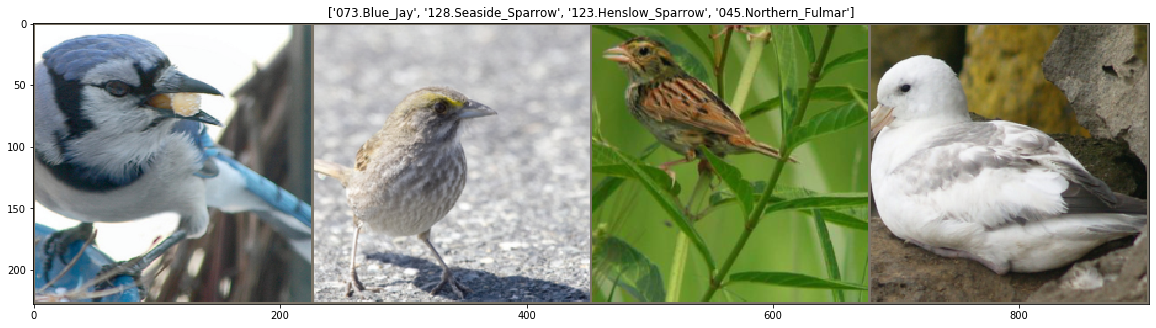

In [139]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [140]:
# Push example inputs to device
inputs = inputs.to(device)
classes = classes.to(device)

# Inference
ts1 = time.time()
outputs = torch_model(inputs)
te1 = time.time()

print('TORCH Inference time: {:8.4f} (seconds)'.format(te1-ts1))

TORCH Inference time:   0.0832 (seconds)


In [141]:
for i_example in np.arange(0,outputs.shape[0], 1):
    pred_class = outputs[i_example].argmax()
    if pred_class == classes[i_example]:
        print('CORRECT PREDICTION')
    else:
        print('!!WRONG PREDICTION!!')
    print('Predicted Label:: {}'.format(class_names[pred_class]))
    print('True Label:: {}'.format(class_names[classes[i_example]]))
    print('')

CORRECT PREDICTION
Predicted Label:: 073.Blue_Jay
True Label:: 073.Blue_Jay

CORRECT PREDICTION
Predicted Label:: 128.Seaside_Sparrow
True Label:: 128.Seaside_Sparrow

CORRECT PREDICTION
Predicted Label:: 123.Henslow_Sparrow
True Label:: 123.Henslow_Sparrow

CORRECT PREDICTION
Predicted Label:: 045.Northern_Fulmar
True Label:: 045.Northern_Fulmar

